In [169]:
import sys
import os
import importlib
import re
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from google import genai
from google.genai.types import HttpOptions
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score, silhouette_score, silhouette_samples, pairwise_distances
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.join(project_dir, 'src', 'utilities'))
import utilities as utils
project_dir

'c:\\Users\\Jonah\\Development\\secular-or-religious'

In [2]:
# Run if changes are made to utilities.py
importlib.reload(utils)

<module 'utilities' from 'c:\\Users\\Jonah\\Development\\secular-or-religious\\src\\utilities\\utilities.py'>

In [3]:
output_dir = os.path.join(project_dir, 'data', 'constitutions_and_laws_tables')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
# Assumes the API key is stored in a .env file
load_dotenv()
GOOGLE_API_KEY = os.getenv('GEMINI_API_KEY')
# Provide gemini timeout in microseconds
GEMINI_TIMEOUT = 5 * 60 * 1000
embedding_client = genai.Client(api_key=GOOGLE_API_KEY, http_options=HttpOptions(timeout=GEMINI_TIMEOUT))


True

## Gathering and parsing ethics
### In this context, an ethic refers to a commandment, law, or moral aspiration.

### Mosaic law / 613 old testament commandments
#### General steps:
1. Extract the book, chapter, starting verse number, and ending verse number from the list of 613 commandments from the html source.
2. Retrieve the King James translation of the verses from another website.
3. Concatenate the verses when a commandment spans multiple verses.
#### Notes:
* If a singular commandment spans multiple verses, then the ethic will be made up of the concatened verses.
* If a single verse contains multiple commandments, the commandments will be represented by one ethic. I could not determine consistent punctuation that delimited commandments in these cases.
* The number of eithics will be less than 613 after all the processing.

In [ ]:
# url_request = requests.get('https://www.gotquestions.org/613-commandments.html')
# url_soup = BeautifulSoup(url_request.content, 'html.parser')
with open(os.path.join(project_dir, 'data', 'website_sources', '613_commandments.html')) as html_file:
    url_soup = BeautifulSoup(html_file, 'html.parser')

In [274]:
url_div = url_soup.find('div', itemprop='articleBody').text
old_testament_verses = re.findall(r'\n\d{1,3}\.\s([a-z]+)\s(\d{1,3}):(\d{1,3})[-\u2013\u2014]?(\d{0,3})', url_div, re.I)
len(old_testament_verses)
old_testament_verses[0]

613

('Genesis', '1', '28', '')

In [ ]:
old_testament_verses_counter = {}
duplicated_old_testament_verses = []
for e in old_testament_verses:
    if e not in old_testament_verses_counter:
        old_testament_verses_counter[e] = 1
    else:
        old_testament_verses_counter[e] += 1
        duplicated_old_testament_verses.append(e)
len(duplicated_old_testament_verses)
for v in duplicated_old_testament_verses[0:10]:
    f'{v} count: {old_testament_verses_counter[v]}'

144

"('Exodus', '12', '46', '') count: 2"

"('Exodus', '12', '48', '') count: 2"

"('Exodus', '13', '13', '') count: 2"

"('Exodus', '20', '5', '') count: 2"

"('Exodus', '21', '8', '') count: 3"

"('Exodus', '21', '8', '') count: 3"

"('Exodus', '21', '28', '') count: 2"

"('Exodus', '22', '21', '') count: 2"

"('Exodus', '22', '25', '') count: 3"

"('Exodus', '22', '25', '') count: 3"

In [278]:
old_testament_verses = list(set(old_testament_verses))
len(old_testament_verses)

469

In [279]:
old_testament_verses = [(t[0], utils.chpt_verse_str_to_int(t[1]), utils.chpt_verse_str_to_int(t[2]), utils.chpt_verse_str_to_int(t[3])) for t in old_testament_verses]

In [534]:
mosaic_law_df = pd.DataFrame(columns=['book', 'book_number', 'chapter', 'starting_verse', 'ending_verse', 'ten_commandments', 'ethic', 'ethic_truncated'])

In [535]:
bible_book_numbers = {
    'Genesis': 1,
    'Exodus': 2,
    'Leviticus': 3,
    'Numbers': 4,
    'Deuteronomy': 5
}
# book, chapter number, range covering first to last verse
# 1 has been added to each last verse number to account for the stop argument not being included
ten_commandments_book_chpt_verses = [('Exodus', 20, range(2, 18)), ('Deuteronomy', 5, range(6, 22))]

In [ ]:
for bcv in old_testament_verses:
    verse_string = ''
    ten_commandments_verse = False
    for tc_bcv in ten_commandments_book_chpt_verses:
        if bcv[0] == tc_bcv[0] and bcv[1] == tc_bcv[1] and bcv[2] in tc_bcv[2]:
            ten_commandments_verse = True
    if bcv[3] > bcv[2]:
        for verse_i in range(bcv[2], bcv[3] + 1):
            url_string = f'https://www.bibleref.com/{bcv[0]}/{bcv[1]}/{bcv[0]}-{bcv[1]}-{verse_i}.html'
            url_request = requests.get(url_string)
            url_soup = BeautifulSoup(url_request.content, 'html.parser')
            url_div = url_soup.find('div', class_='bottomPadding kjv').text.strip('\n\'" KJV')
            if not verse_string:
                verse_string = url_div
            else:
                verse_string = f'{verse_string} {url_div}'
    else:
        url_string = f'https://www.bibleref.com/{bcv[0]}/{bcv[1]}/{bcv[0]}-{bcv[1]}-{bcv[2]}.html'
        url_request = requests.get(url_string)
        url_soup = BeautifulSoup(url_request.content, 'html.parser')
        verse_string = url_soup.find('div', class_='bottomPadding kjv').text.strip('\n\'" KJV')
        verse_string
    mosaic_law_df.loc[len(mosaic_law_df)] = [bcv[0], bible_book_numbers[bcv[0]], bcv[1], bcv[2], bcv[3], ten_commandments_verse, verse_string, utils.truncate(verse_string)]
        

In [537]:
mosaic_law_df = mosaic_law_df.sort_values(by=['book_number', 'chapter', 'starting_verse']).reset_index(drop=True)

In [211]:
mosaic_law_df['ending_verse'] = mosaic_law_df['ending_verse'].astype(float)

In [214]:
mosaic_law_df = mosaic_law_df.reindex(['book', 'book_number', 'chapter', 'starting_verse', 'ending_verse', 'ten_commandments', 'ethic', 'ethic_truncated'], axis=1)

In [544]:
mosaic_law_df.loc[mosaic_law_df['ten_commandments']]

,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
21,Exodus,2,20,3,NaN,True,Thou shalt have no other gods before me.,Thou shalt have no other gods before me.
22,Exodus,2,20,4,NaN,True,Thou shalt not make unto thee any graven image...,Thou shalt not make unto thee any graven image...
23,Exodus,2,20,5,NaN,True,"Thou shalt not bow down thyself to them, nor s...","Thou shalt not bow down thyself to them, nor s..."
24,Exodus,2,20,7,NaN,True,Thou shalt not take the name of the Lord thy G...,Thou shalt not take the name of the Lord thy G...
25,Exodus,2,20,8,NaN,True,"Remember the sabbath day, to keep it holy.","Remember the sabbath day, to keep it holy."
26,Exodus,2,20,10,NaN,True,But the seventh day is the sabbath of the Lord...,But the seventh day is the sabbath of the Lord...
27,Exodus,2,20,12,NaN,True,Honour thy father and thy mother: that thy day...,Honour thy father and thy mother: that thy day...
28,Exodus,2,20,13,NaN,True,Thou shalt not kill.,Thou shalt not kill.
29,Exodus,2,20,14,NaN,True,Thou shalt not commit adultery.,Thou shalt not commit adultery.
30,Exodus,2,20,15,NaN,True,Thou shalt not steal.,Thou shalt not steal.


In [541]:
mosaic_law_df.reindex(['book_number', 'chapter', 'starting_verse'], axis=1).duplicated().value_counts()
mosaic_law_df['ethic_truncated'].duplicated().value_counts()

False    469
Name: count, dtype: int64

ethic_truncated
False    465
True       4
Name: count, dtype: int64

### Sermon on the mount
#### General steps:
1. Determine which verses in the book of Matthew contain the ethics preached by Jesus during the sermon.
2. Retrieve the King James translation of the verses from another website.
#### Notes:
* Each verse will be treated as one ethic.

In [ ]:
# Source: https://www.biblegateway.com/passage/?search=Matthew%205-7&version=NIV
sermon_on_the_mount_chpt_verse_numbers = {5: (3, 48), 6: (1, 34), 7: (1, 27)}

In [547]:
sermon_on_the_mount_df = pd.DataFrame(columns=['book', 'book_number', 'chapter', 'starting_verse', 'ending_verse', 'ten_commandments', 'ethic', 'ethic_truncated'])

In [ ]:
for chpt_num in sermon_on_the_mount_chpt_verse_numbers:
    book_name = 'Matthew'
    chpt_verses_span = sermon_on_the_mount_chpt_verse_numbers[chpt_num]
    for verse_num in range(chpt_verses_span[0], chpt_verses_span[1] + 1):
        verse_string = ''
        url_string = f'https://www.bibleref.com/{book_name}/{chpt_num}/{book_name}-{chpt_num}-{verse_num}.html'
        url_request = requests.get(url_string)
        url_soup = BeautifulSoup(url_request.content, 'html.parser')
        verse_string = url_soup.find('div', class_='bottomPadding kjv').text.strip('\n\'" KJV')
        sermon_on_the_mount_df.loc[len(sermon_on_the_mount_df)] = [book_name, 40, chpt_num, verse_num, np.nan, False, verse_string, utils.truncate(verse_string)]

In [558]:
sermon_on_the_mount_df = sermon_on_the_mount_df.sort_values(by=['book_number', 'chapter', 'starting_verse']).reset_index(drop=True)
sermon_on_the_mount_df.head()
sermon_on_the_mount_df.tail()

,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
0,Matthew,40,5,3,NaN,False,Blessed are the poor in spirit: for theirs is ...,Blessed are the poor in spirit: for theirs is ...
1,Matthew,40,5,4,NaN,False,Blessed are they that mourn: for they shall be...,Blessed are they that mourn: for they shall be...
2,Matthew,40,5,5,NaN,False,Blessed are the meek: for they shall inherit t...,Blessed are the meek: for they shall inherit t...
3,Matthew,40,5,6,NaN,False,Blessed are they which do hunger and thirst af...,Blessed are they which do hunger and thirst af...
4,Matthew,40,5,7,NaN,False,Blessed are the merciful: for they shall obtai...,Blessed are the merciful: for they shall obtai...


,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
102,Matthew,40,7,23,NaN,False,"And then will I profess unto them, I never kne...","And then will I profess unto them, I never kne..."
103,Matthew,40,7,24,NaN,False,Therefore whosoever heareth these sayings of m...,Therefore whosoever heareth these sayings of m...
104,Matthew,40,7,25,NaN,False,"And the rain descended, and the floods came, a...","And the rain descended, and the floods came, a..."
105,Matthew,40,7,26,NaN,False,And every one that heareth these sayings of mi...,And every one that heareth these sayings of mi...
106,Matthew,40,7,27,NaN,False,"And the rain descended, and the floods came, a...","And the rain descended, and the floods came, a..."


### 100 commandments from the Quran
#### General steps:
1. Extract the chapter and verse number from the list of 100 commandments from the html source.
2. Retrieve the verses from another website.
#### Notes:
* Each commandment was made up of a singular verse.
* Include book and book_number, and ten_commandments columns so the dataframes containing Bible and Quran data have the same structure.

In [ ]:
# url_request = requests.get('https://messageinternational.org/100-commandments-and-doctrines-from-the-quran/')
# url_soup = BeautifulSoup(url_request.content, 'html.parser') 
with open(os.path.join(project_dir, 'data', 'website_sources', 'quran_100_commandments.html')) as html_file:
    url_soup = BeautifulSoup(html_file, 'html.parser')

In [560]:
url_div = url_soup.find('div', class_='entry-content content').text
quran_verses = re.findall(r'\n\d{1,3}\..*\((\d{1,3}):(\d{1,3})\)', url_div, re.I)
len(quran_verses)
quran_verses[0]

100

('3', '159')

In [561]:
quran_verses_counter = {}
duplicated_quran_verses = []
for e in quran_verses:
    if e not in quran_verses_counter:
        quran_verses_counter[e] = 1
    else:
        quran_verses_counter[e] += 1
        duplicated_quran_verses.append(e)
len(duplicated_quran_verses)
for v in duplicated_quran_verses:
    f'{v} count: {quran_verses_counter[v]}'

7

"('17', '23') count: 2"

"('4', '7') count: 2"

"('5', '90') count: 2"

"('7', '31') count: 2"

"('3', '191') count: 2"

"('5', '8') count: 2"

"('2', '190') count: 2"

In [562]:
quran_verses = list(set(quran_verses))
len(quran_verses)

93

In [563]:
quran_verses = [(utils.chpt_verse_str_to_int(t[0]), utils.chpt_verse_str_to_int(t[1])) for t in quran_verses]

In [564]:
quran_law_df = pd.DataFrame(columns=['book', 'book_number', 'chapter', 'starting_verse', 'ending_verse', 'ten_commandments', 'ethic', 'ethic_truncated'])

In [ ]:
for bcv in quran_verses:
    verse_string = ''
    chpt = bcv[0]
    if chpt < 10:
        chpt = f'00{chpt}'
    elif chpt < 100:
        chpt = f'0{chpt}'
    else:
        chpt = f'{chpt}'
    url_string = f'https://www.clearquran.com/{chpt}.html'
    url_request = requests.get(url_string)
    url_soup = BeautifulSoup(url_request.content, 'html.parser')
    url_div = url_soup.find('div', id='quran-text').text
    verse_string = re.search(r'\n' + str(bcv[1]) + r'\.\s{1,2}(.*)\n', url_div)
    if verse_string:
        verse_string = verse_string.group(1).strip('\n\'" ')
    quran_law_df.loc[len(quran_law_df)] = ['NA', np.nan, bcv[0], bcv[1], np.nan, False, verse_string, utils.truncate(verse_string)]

In [566]:
quran_law_df.shape
quran_law_df.tail()

(93, 8)

,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
88,NA,NaN,24,58,NaN,False,O you who believe! Permission must be requeste...,O you who believe! Permission must be requeste...
89,NA,NaN,2,273,NaN,False,It is for the poor; those who are restrained i...,It is for the poor; those who are restrained i...
90,NA,NaN,57,27,NaN,False,"Then We sent in their wake Our messengers, and...","Then We sent in their wake Our messengers, and..."
91,NA,NaN,10,58,NaN,False,"Say, “In God’s grace and mercy let them rejoic...","Say, “In God’s grace and mercy let them rejoic..."
92,NA,NaN,31,4,NaN,False,"Those who observe the prayer, and pay the obli...","Those who observe the prayer, and pay the obli..."


In [567]:
quran_law_df = quran_law_df.sort_values(by=['chapter', 'starting_verse']).reset_index(drop=True)

In [568]:
quran_law_df.shape
quran_law_df.head()
quran_law_df.tail()

(93, 8)

,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
0,NA,NaN,2,42,NaN,False,"And do not mix truth with falsehood, and do no...","And do not mix truth with falsehood, and do no..."
1,NA,NaN,2,44,NaN,False,"Do you command people to virtuous conduct, and...","Do you command people to virtuous conduct, and..."
2,NA,NaN,2,60,NaN,False,And recall when Moses prayed for water for his...,And recall when Moses prayed for water for his...
3,NA,NaN,2,114,NaN,False,Who is more unjust than him who forbids the re...,Who is more unjust than him who forbids the re...
4,NA,NaN,2,170,NaN,False,"And when it is said to them, “Follow what God ...","And when it is said to them, “Follow what God ..."


,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
88,NA,NaN,64,16,NaN,False,"So be conscious of God as much as you can, and...","So be conscious of God as much as you can, and..."
89,NA,NaN,90,17,NaN,False,"Then he becomes of those who believe, and advi...","Then he becomes of those who believe, and advi..."
90,NA,NaN,91,10,NaN,False,Failing is he who corrupts it.,Failing is he who corrupts it.
91,NA,NaN,93,10,NaN,False,Nor rebuff the seeker.,Nor rebuff the seeker.
92,NA,NaN,107,3,NaN,False,And does not encourage the feeding of the poor.,And does not encourage the feeding of the poor.


### Last sermon
#### General steps:
1. Determine the indexes of the paragraphs that contain quotes of Muhammad from the source html.
2. Extract the text from each of these paragraphs. 
#### Notes:
* Each paragraph will be treated as one ethic.
* Include book, book_number, chapter, starting_verse, ending_verse, and ten_commandments columns so the dataframes containing Bible and Quran data have the same structure.

In [222]:
# url_request = requests.get('https://www.iium.edu.my/deed/articles/thelastsermon.html')
# url_soup = BeautifulSoup(url_request.content, 'html.parser')
with open(os.path.join(project_dir, 'data', 'website_sources', 'the_last_sermon.html')) as html_file:
    url_soup = BeautifulSoup(html_file, 'html.parser')
url_paragraphs = url_soup.find_all('p')
last_sermon_verses = [p.text.strip('\n\'" ') for p in url_paragraphs]
start_index = None
end_index = None
for i, verse_string in enumerate(last_sermon_verses):
    if re.match('O People! Lend me an attentive ear, for I know not whether after this', verse_string):
        start_index = i
    if re.match('O Allah, be my witness, that I have conveyed your message to Your people', verse_string):
        end_index = i
last_sermon_verses = last_sermon_verses[start_index:end_index+1]
last_sermon_df = pd.DataFrame(columns=['book', 'book_number', 'chapter', 'starting_verse', 'ending_verse', 'ten_commandments', 'ethic', 'ethic_truncated'])
for i, verse_string in enumerate(last_sermon_verses):
    last_sermon_df.loc[len(last_sermon_df)] = ['NA', np.nan, 1, i+1, np.nan, False, verse_string, utils.truncate(verse_string)]


In [224]:
last_sermon_df.shape
last_sermon_df.head()
last_sermon_df.tail()

(13, 8)

,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
0,NA,NaN,1,1,NaN,False,"O People! Lend me an attentive ear, for I know...","O People! Lend me an attentive ear, for I know..."
1,NA,NaN,1,2,NaN,False,"O People! just as you regard this month, this ...","O People! just as you regard this month, this ..."
2,NA,NaN,1,3,NaN,False,"Allah has forbidden you to take usury, therefo...","Allah has forbidden you to take usury, therefo..."
3,NA,NaN,1,4,NaN,False,Every right arising out of homicide in pre-Isl...,Every right arising out of homicide in pre-Isl...
4,NA,NaN,1,5,NaN,False,O men! the unbelievers indulge in tampering wi...,O men! the unbelievers indulge in tampering wi...


(13, 16)

,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
669,Last sermon,<NA>,<NA>,1,1,<NA>,False,False,False,False,False,False,False,"O People! Lend me an attentive ear, for I know...","O People! Lend me an attentive ear, for I know...",<NA>
670,Last sermon,<NA>,<NA>,1,2,<NA>,False,False,False,False,False,False,False,"O People! just as you regard this month, this ...","O People! just as you regard this month, this ...","O People! just as you regard this month, this ..."
671,Last sermon,<NA>,<NA>,1,3,<NA>,False,False,False,False,False,False,False,"Allah has forbidden you to take usury, therefo...","Allah has forbidden you to take usury, therefo...","God has forbidden you to take usury, therefore..."
672,Last sermon,<NA>,<NA>,1,4,<NA>,False,False,False,False,False,False,False,Every right arising out of homicide in pre-Isl...,Every right arising out of homicide in pre-Isl...,<NA>
673,Last sermon,<NA>,<NA>,1,5,<NA>,False,False,False,False,False,False,False,O men! the unbelievers indulge in tampering wi...,O men! the unbelievers indulge in tampering wi...,O men! the unbelievers indulge in tampering wi...


,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,ethic,ethic_truncated
8,NA,NaN,1,9,NaN,False,"All mankind is from Adam and Eve, an Arab has ...","All mankind is from Adam and Eve, an Arab has ..."
9,NA,NaN,1,10,NaN,False,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...
10,NA,NaN,1,11,NaN,False,O People! No Prophet or apostle will come afte...,O People! No Prophet or apostle will come afte...
11,NA,NaN,1,12,NaN,False,All those who listen to me shall pass on my wo...,All those who listen to me shall pass on my wo...
12,NA,NaN,1,13,NaN,False,"O Allah, be my witness, that I have conveyed y...","O Allah, be my witness, that I have conveyed y..."


,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
677,Last sermon,<NA>,<NA>,1,9,<NA>,False,False,False,False,False,False,False,"All mankind is from Adam and Eve, an Arab has ...","All mankind is from Adam and Eve, an Arab has ...",<NA>
678,Last sermon,<NA>,<NA>,1,10,<NA>,False,False,False,False,False,False,False,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...
679,Last sermon,<NA>,<NA>,1,11,<NA>,False,False,False,False,False,False,False,O People! No Prophet or apostle will come afte...,O People! No Prophet or apostle will come afte...,<NA>
680,Last sermon,<NA>,<NA>,1,12,<NA>,False,False,False,False,False,False,False,All those who listen to me shall pass on my wo...,All those who listen to me shall pass on my wo...,<NA>
681,Last sermon,<NA>,<NA>,1,13,<NA>,False,False,False,False,False,False,False,"O Allah, be my witness, that I have conveyed y...","O Allah, be my witness, that I have conveyed y...","O God, be my witness, that I have conveyed you..."


### Code of Hammurabi
#### General steps:
1. Copy the codes and epilouge into a text file, as the html from the source website is malformed so the BeautifulSoup library doesn't work well for it. 
2. Process each line as an ethic.
#### Notes:
* The paragraph elements, \<p>, were missing the cloing <\p>.

In [21]:
code_of_hammurabi_lines = []
# Source: https://avalon.law.yale.edu/ancient/hamframe.asp
with open(os.path.join(project_dir, 'data', 'website_sources', 'code_of_hammurabi.txt')) as text_file:
    for line in text_file:
        processed_line = line.strip('"\'\n ')
        if processed_line and processed_line not in ['CODE OF LAWS', 'THE EPILOGUE']:
            code_of_hammurabi_lines.append(processed_line)

In [22]:
len(code_of_hammurabi_lines)
code_of_hammurabi_lines[0:5]
code_of_hammurabi_lines[-5:]

254

['1. If any one ensnare another, putting a ban upon him, but he can not prove it, then he that ensnared him shall be put to death.',
 '2. If any one bring an accusation against a man, and the accused go to the river and leap into the river, if he sink in the river his accuser shall take possession of his house. But if the river prove that the accused is not guilty, and he escape unhurt, then he who had brought the accusation shall be put to death, while he who leaped into the river shall take possession of the house that had belonged to his accuser.',
 '3. If any one bring an accusation of any crime before the elders, and does not prove what he has charged, he shall, if it be a capital offense charged, be put to death.',
 '4. If he satisfy the elders to impose a fine of grain or money, he shall receive the fine that the action produces.',
 "5. If a judge try a case, reach a decision, and present his judgment in writing; if later error shall appear in his decision, and it be through his

['Hammurabi is a ruler, who is as a father to his subjects, who holds the words of Marduk in reverence, who has achieved conquest for Marduk over the north and south, who rejoices the heart of Marduk, his lord, who has bestowed benefits for ever and ever on his subjects, and has established order in the land.',
 'When he reads the record, let him pray with full heart to Marduk, my lord, and Zarpanit, my lady; and then shall the protecting deities and the gods, who frequent E-Sagil, graciously grant the desires daily presented before Marduk, my lord, and Zarpanit, my lady.',
 'In future time, through all coming generations, let the king, who may be in the land, observe the words of righteousness which I have written on my monument; let him not alter the law of the land which I have given, the edicts which I have enacted; my monument let him not mar. If such a ruler have wisdom, and be able to keep his land in order, he shall observe the words which I have written in this inscription; th

In [36]:
hammurabi_df = pd.DataFrame(columns=['law', 'epilogue', 'ethic', 'ethic_truncated'])

In [37]:
for line in code_of_hammurabi_lines:
    statement = line
    law = False
    epilogue = True
    # The laws are enumerated 1 to 282
    # Laws 66 to 99 are missing
    law_check = re.match(r'\d{1,3}\.?\s(.*)', statement, re.I)
    if law_check:
        statement = law_check.group(1)
        law = True
        epilogue = False
    hammurabi_df.loc[len(hammurabi_df)] = [law, epilogue, statement, utils.truncate(statement)]

In [38]:
hammurabi_df.loc[hammurabi_df['law']].shape
hammurabi_df.loc[hammurabi_df['law']].head(10)
hammurabi_df.loc[hammurabi_df['epilogue']].head(10)

(247, 4)

,law,epilogue,ethic,ethic_truncated
0,True,False,"If any one ensnare another, putting a ban upon...","If any one ensnare another, putting a ban upon..."
1,True,False,"If any one bring an accusation against a man, ...","If any one bring an accusation against a man, ..."
2,True,False,If any one bring an accusation of any crime be...,If any one bring an accusation of any crime be...
3,True,False,If he satisfy the elders to impose a fine of g...,If he satisfy the elders to impose a fine of g...
4,True,False,"If a judge try a case, reach a decision, and p...","If a judge try a case, reach a decision, and p..."
5,True,False,If any one steal the property of a temple or o...,If any one steal the property of a temple or o...
6,True,False,If any one buy from the son or the slave of an...,If any one buy from the son or the slave of an...
7,True,False,"If any one steal cattle or sheep, or an ass, o...","If any one steal cattle or sheep, or an ass, o..."
8,True,False,"If any one lose an article, and find it in the...","If any one lose an article, and find it in the..."
9,True,False,If the purchaser does not bring the merchant a...,If the purchaser does not bring the merchant a...


,law,epilogue,ethic,ethic_truncated
247,False,True,"LAWS of justice which Hammurabi, the wise king...","LAWS of justice which Hammurabi, the wise king..."
248,False,True,The king who ruleth among the kings of the cit...,The king who ruleth among the kings of the cit...
249,False,True,"Hammurabi is a ruler, who is as a father to hi...","Hammurabi is a ruler, who is as a father to hi..."
250,False,True,"When he reads the record, let him pray with fu...","When he reads the record, let him pray with fu..."
251,False,True,"In future time, through all coming generations...","In future time, through all coming generations..."
252,False,True,"Hammurabi, the king of righteousness, on whom ...","Hammurabi, the king of righteousness, on whom ..."
253,False,True,"May he lament the loss of his life-power, and ...","May he lament the loss of his life-power, and ..."


### US constitution
#### General steps:
1. Extract the paragraphs from the html source.
2. Determine the indexes of the paragraphs that contain the preamble and the last amendment from the html source.
3. Save each paragraph as an ethic and determine if the paragraph is from the preamble, an article, an amendment (or more specifically from the bill of rights) based on the index.
#### Notes:
* Each paragraph is treated as one ethic.
* Articles and amendments that contain multiple paragraphs are represented by multiple ethics. None of the bill of rights contain more than one paragraph, so the bill of rights are not affected by this. 

In [ ]:
# url_request = requests.get('https://constitutioncenter.org/the-constitution/full-text')
# url_soup = BeautifulSoup(url_request.content, 'html.parser')
with open(os.path.join(project_dir, 'data', 'website_sources', 'the_usa_constitution.html')) as html_file:
    url_soup = BeautifulSoup(html_file, 'html.parser')

In [584]:
url_paragraphs = url_soup.find_all('p')
len(url_paragraphs)
url_paragraphs[0:5]
url_paragraphs[-5:]

140

[<p data-load="/ajax/museum-hours">Loadin...</p>,
 <p>We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defence, promote the general Welfare, and secure the Blessings of Liberty to ourselves and our Posterity, do ordain and establish this Constitution for the United States of America.</p>,
 <p>All legislative Powers herein granted shall be vested in a Congress of the United States, which shall consist of a Senate and House of Representatives.</p>,
 <p><span id="section-2">The House of Representatives shall be composed of Members chosen every second Year by the People of the several States, and the Electors in each State shall have the Qualifications requisite for Electors of the most numerous Branch of the State Legislature.</span></p>,
 <p>No Person shall be a Representative who shall not have attained to the Age of twenty five Years, and been seven Years a Citizen of the United States, and

[<p>The right of citizens of the United States, who are eighteen years of age or older, to vote shall not be denied or abridged by the United States or by any State on account of age.</p>,
 <p>The Congress shall have power to enforce this article by appropriate legislation.</p>,
 <p>No law, varying the compensation for the services of the Senators and Representatives, shall take effect, until an election of Representatives shall have intervened.</p>,
 <p class="mb-3 mb-lg-0 site-footer__text">© 2025 National Constitution Center. All Rights Reserved.</p>,
 <p>Modal body text goes here.</p>]

In [585]:
constitution_statements = [p.text.strip('\n\'" ') for p in url_paragraphs[1:138]]
constitution_statements[0:5]
constitution_statements[-5:]

['We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defence, promote the general Welfare, and secure the Blessings of Liberty to ourselves and our Posterity, do ordain and establish this Constitution for the United States of America.',
 'All legislative Powers herein granted shall be vested in a Congress of the United States, which shall consist of a Senate and House of Representatives.',
 'The House of Representatives shall be composed of Members chosen every second Year by the People of the several States, and the Electors in each State shall have the Qualifications requisite for Electors of the most numerous Branch of the State Legislature.',
 'No Person shall be a Representative who shall not have attained to the Age of twenty five Years, and been seven Years a Citizen of the United States, and who shall not, when elected, be an Inhabitant of that State in which he shall be chosen.',
 'R

['Whenever the President transmits to the President pro tempore of the Senate and the Speaker of the House of Representatives his written declaration that he is unable to discharge the powers and duties of his office, and until he transmits to them a written declaration to the contrary, such powers and duties shall be discharged by the Vice President as Acting President.',
 'Whenever the Vice President and a majority of either the principal officers of the executive departments or of such other body as Congress may by law provide, transmit to the President pro tempore of the Senate and the Speaker of the House of Representatives their written declaration that the President is unable to discharge the powers and duties of his office, the Vice President shall immediately assume the powers and duties of the office as Acting President.\n\xa0\xa0\xa0\xa0\xa0\nThereafter, when the President transmits to the President pro tempore of the Senate and the Speaker of the House of Representatives hi

In [586]:
preamble_index = None
amendment_index = None
for i, statement in enumerate(constitution_statements):
    if re.match('We the People of the United States, in Order to form a more perfect Union', statement):
        preamble_index = i
    if re.match('Congress shall make no law respecting an establishment of religion', statement):
        amendment_index = i
preamble_index
amendment_index

0

86

In [587]:
constitution_df = pd.DataFrame(columns=['preamble', 'article', 'bill_of_rights', 'amendment', 'ethic', 'ethic_truncated'])

In [588]:
amendment_count = 0
for i, statement in enumerate(constitution_statements):
    preamble = False
    article = False
    amendment = False
    bill_of_rights = False
    if i == preamble_index:
        preamble = True
    elif i < amendment_index:
        article = True
    elif i >= amendment_index:
        amendment = True
        if amendment_count < 10:
            bill_of_rights = True
        amendment_count += 1
    constitution_df.loc[len(constitution_df)] = [preamble, article, bill_of_rights, amendment, statement, utils.truncate(statement)]

In [589]:
constitution_df.shape
constitution_df.head()
constitution_df.tail()

(137, 6)

,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
0,True,False,False,False,"We the People of the United States, in Order t...","We the People of the United States, in Order t..."
1,False,True,False,False,All legislative Powers herein granted shall be...,All legislative Powers herein granted shall be...
2,False,True,False,False,The House of Representatives shall be composed...,The House of Representatives shall be composed...
3,False,True,False,False,No Person shall be a Representative who shall ...,No Person shall be a Representative who shall ...
4,False,True,False,False,Representatives and direct Taxes shall be appo...,Representatives and direct Taxes shall be appo...


,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
132,False,False,False,True,Whenever the President transmits to the Presid...,Whenever the President transmits to the Presid...
133,False,False,False,True,Whenever the Vice President and a majority of ...,Whenever the Vice President and a majority of ...
134,False,False,False,True,"The right of citizens of the United States, wh...","The right of citizens of the United States, wh..."
135,False,False,False,True,The Congress shall have power to enforce this ...,The Congress shall have power to enforce this ...
136,False,False,False,True,"No law, varying the compensation for the servi...","No law, varying the compensation for the servi..."


In [656]:
constitution_df.loc[constitution_df['bill_of_rights']]

,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
86,False,False,True,True,Congress shall make no law respecting an estab...,Congress shall make no law respecting an estab...
87,False,False,True,True,"A well regulated Militia, being necessary to t...","A well regulated Militia, being necessary to t..."
88,False,False,True,True,"No Soldier shall, in time of peace be quartere...","No Soldier shall, in time of peace be quartere..."
89,False,False,True,True,The right of the people to be secure in their ...,The right of the people to be secure in their ...
90,False,False,True,True,No person shall be held to answer for a capita...,No person shall be held to answer for a capita...
91,False,False,True,True,"In all criminal prosecutions, the accused shal...","In all criminal prosecutions, the accused shal..."
92,False,False,True,True,"In Suits at common law, where the value in con...","In Suits at common law, where the value in con..."
93,False,False,True,True,"Excessive bail shall not be required, nor exce...","Excessive bail shall not be required, nor exce..."
94,False,False,True,True,"The enumeration in the Constitution, of certai...","The enumeration in the Constitution, of certai..."
95,False,False,True,True,The powers not delegated to the United States ...,The powers not delegated to the United States ...


### Combine the ethics from all the sources

In [132]:
combined_df = pd.concat([
    mosaic_law_df.assign(source='Mosaic'), sermon_on_the_mount_df.assign(source='Sermon on the mount'), quran_law_df.assign(source='Quran'),
    last_sermon_df.assign(source='Last sermon'), hammurabi_df.assign(source='Hammurabi code'), constitution_df.assign(source='US constitution')
], ignore_index=True)

combined_df = combined_df.reindex([
    'source', 'book', 'book_number',
    'chapter', 'starting_verse', 'ending_verse',
    'ten_commandments', 'law', 'epilogue',
    'preamble', 'article', 'bill_of_rights',
    'amendment', 'ethic', 'ethic_truncated'
], axis=1)

combined_df.shape

(1073, 15)

In [ ]:
combined_column_types = {
    'text': ['source', 'book', 'ethic', 'ethic_truncated'],
    'number': ['book_number', 'chapter', 'starting_verse', 'ending_verse'],
    'bool': ['ten_commandments', 'law', 'epilogue', 'preamble', 'article', 'bill_of_rights', 'amendment']
}

In [225]:
# TODO: Use pd.NA instead of 'NA' and np.nan when initally populating the dataframes instead of converting them below.

In [ ]:
for col in combined_df:
    if col in combined_column_types['text']:
        combined_df[col] = combined_df[col].convert_dtypes().fillna(pd.NA).replace('NA', pd.NA)
    elif col in combined_column_types['number']:
        combined_df[col] = combined_df[col].convert_dtypes().fillna(pd.NA).replace(np.nan, pd.NA)
    elif col in combined_column_types['bool']:
        combined_df[col] = combined_df[col].convert_dtypes().fillna(False).replace(np.nan, False)

In [134]:
combined_df.shape
combined_df.dtypes
combined_df.head()
combined_df.tail()

(1073, 15)

source              string[python]
book                string[python]
book_number                  Int64
chapter                      Int64
starting_verse               Int64
ending_verse                 Int64
ten_commandments           boolean
law                        boolean
epilogue                   boolean
preamble                   boolean
article                    boolean
bill_of_rights             boolean
amendment                  boolean
ethic               string[python]
ethic_truncated     string[python]
dtype: object

,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
0,Mosaic,Genesis,1,1,28,<NA>,False,False,False,False,False,False,False,"And God blessed them, and God said unto them, ...","And God blessed them, and God said unto them, ..."
1,Mosaic,Genesis,1,32,32,<NA>,False,False,False,False,False,False,False,Therefore the children of Israel eat not of th...,Therefore the children of Israel eat not of th...
2,Mosaic,Exodus,2,12,2,<NA>,False,False,False,False,False,False,False,This month shall be unto you the beginning of ...,This month shall be unto you the beginning of ...
3,Mosaic,Exodus,2,12,6,<NA>,False,False,False,False,False,False,False,And ye shall keep it up until the fourteenth d...,And ye shall keep it up until the fourteenth d...
4,Mosaic,Exodus,2,12,8,<NA>,False,False,False,False,False,False,False,"And they shall eat the flesh in that night, ro...","And they shall eat the flesh in that night, ro..."


,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
1068,US constitution,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,False,False,False,True,Whenever the President transmits to the Presid...,Whenever the President transmits to the Presid...
1069,US constitution,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,False,False,False,True,Whenever the Vice President and a majority of ...,Whenever the Vice President and a majority of ...
1070,US constitution,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,False,False,False,True,"The right of citizens of the United States, wh...","The right of citizens of the United States, wh..."
1071,US constitution,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,False,False,False,True,The Congress shall have power to enforce this ...,The Congress shall have power to enforce this ...
1072,US constitution,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,False,False,False,False,True,"No law, varying the compensation for the servi...","No law, varying the compensation for the servi..."


In [135]:
combined_df.loc[~combined_df['book'].isna()].head()
combined_df.loc[~combined_df['book'].isna()].tail()

,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
0,Mosaic,Genesis,1,1,28,<NA>,False,False,False,False,False,False,False,"And God blessed them, and God said unto them, ...","And God blessed them, and God said unto them, ..."
1,Mosaic,Genesis,1,32,32,<NA>,False,False,False,False,False,False,False,Therefore the children of Israel eat not of th...,Therefore the children of Israel eat not of th...
2,Mosaic,Exodus,2,12,2,<NA>,False,False,False,False,False,False,False,This month shall be unto you the beginning of ...,This month shall be unto you the beginning of ...
3,Mosaic,Exodus,2,12,6,<NA>,False,False,False,False,False,False,False,And ye shall keep it up until the fourteenth d...,And ye shall keep it up until the fourteenth d...
4,Mosaic,Exodus,2,12,8,<NA>,False,False,False,False,False,False,False,"And they shall eat the flesh in that night, ro...","And they shall eat the flesh in that night, ro..."


,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated
571,Sermon on the mount,Matthew,40,7,23,<NA>,False,False,False,False,False,False,False,"And then will I profess unto them, I never kne...","And then will I profess unto them, I never kne..."
572,Sermon on the mount,Matthew,40,7,24,<NA>,False,False,False,False,False,False,False,Therefore whosoever heareth these sayings of m...,Therefore whosoever heareth these sayings of m...
573,Sermon on the mount,Matthew,40,7,25,<NA>,False,False,False,False,False,False,False,"And the rain descended, and the floods came, a...","And the rain descended, and the floods came, a..."
574,Sermon on the mount,Matthew,40,7,26,<NA>,False,False,False,False,False,False,False,And every one that heareth these sayings of mi...,And every one that heareth these sayings of mi...
575,Sermon on the mount,Matthew,40,7,27,<NA>,False,False,False,False,False,False,False,"And the rain descended, and the floods came, a...","And the rain descended, and the floods came, a..."


In [218]:
combined_df.loc[combined_df['source'] == 'Last sermon'].head()
combined_df.loc[combined_df['source'] == 'Last sermon'].tail()

,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
669,Last sermon,<NA>,<NA>,1,1,<NA>,False,False,False,False,False,False,False,"O People! Lend me an attentive ear, for I know...","O People! Lend me an attentive ear, for I know...",<NA>
670,Last sermon,<NA>,<NA>,1,2,<NA>,False,False,False,False,False,False,False,"O People! just as you regard this month, this ...","O People! just as you regard this month, this ...","O People! just as you regard this month, this ..."
671,Last sermon,<NA>,<NA>,1,3,<NA>,False,False,False,False,False,False,False,"Allah has forbidden you to take usury, therefo...","Allah has forbidden you to take usury, therefo...","God has forbidden you to take usury, therefore..."
672,Last sermon,<NA>,<NA>,1,4,<NA>,False,False,False,False,False,False,False,Every right arising out of homicide in pre-Isl...,Every right arising out of homicide in pre-Isl...,<NA>
673,Last sermon,<NA>,<NA>,1,5,<NA>,False,False,False,False,False,False,False,O men! the unbelievers indulge in tampering wi...,O men! the unbelievers indulge in tampering wi...,O men! the unbelievers indulge in tampering wi...


,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
677,Last sermon,<NA>,<NA>,1,9,<NA>,False,False,False,False,False,False,False,"All mankind is from Adam and Eve, an Arab has ...","All mankind is from Adam and Eve, an Arab has ...",<NA>
678,Last sermon,<NA>,<NA>,1,10,<NA>,False,False,False,False,False,False,False,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...
679,Last sermon,<NA>,<NA>,1,11,<NA>,False,False,False,False,False,False,False,O People! No Prophet or apostle will come afte...,O People! No Prophet or apostle will come afte...,<NA>
680,Last sermon,<NA>,<NA>,1,12,<NA>,False,False,False,False,False,False,False,All those who listen to me shall pass on my wo...,All those who listen to me shall pass on my wo...,<NA>
681,Last sermon,<NA>,<NA>,1,13,<NA>,False,False,False,False,False,False,False,"O Allah, be my witness, that I have conveyed y...","O Allah, be my witness, that I have conveyed y...","O God, be my witness, that I have conveyed you..."


In [154]:
god_referene_count = {'God': 0, 'Lord': 0, 'Father': 0, 'Jehovah': 0, 'Yahweh': 0, 'Allah': 0}
for verse in combined_df['ethic'].to_list():
    god_search = re.search(r'(God|Lord|Father|Jehovah|Yahweh|Allah)', verse) 
    if god_search:
        god_referene_count[god_search.group(0)] += 1
god_referene_count

{'God': 89, 'Lord': 155, 'Father': 14, 'Jehovah': 0, 'Yahweh': 0, 'Allah': 6}

In [150]:
combined_df['standardized_ethic'] = pd.NA
for i, row in combined_df.iterrows():
    ethic = row['ethic']
    god_search = re.search(r'(Lord|Father|Jehovah|Yahweh|Allah)', ethic)
    if god_search:
        combined_df.loc[i, 'standardized_ethic'] = re.sub(r'Lord|Father|Jehovah|Yahweh|Allah', 'God', ethic)

In [153]:
combined_df.loc[~combined_df['standardized_ethic'].isna()].head()
combined_df.loc[~combined_df['standardized_ethic'].isna()].tail()

,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
11,Mosaic,Exodus,2,12,43,<NA>,False,False,False,False,False,False,False,"And the Lord said unto Moses and Aaron, This i...","And the Lord said unto Moses and Aaron, This i...","And the God said unto Moses and Aaron, This is..."
14,Mosaic,Exodus,2,12,48,<NA>,False,False,False,False,False,False,False,"And when a stranger shall sojourn with thee, a...","And when a stranger shall sojourn with thee, a...","And when a stranger shall sojourn with thee, a..."
15,Mosaic,Exodus,2,13,3,<NA>,False,False,False,False,False,False,False,"And Moses said unto the people, Remember this ...","And Moses said unto the people, Remember this ...","And Moses said unto the people, Remember this ..."
17,Mosaic,Exodus,2,13,8,<NA>,False,False,False,False,False,False,False,"And thou shalt shew thy son in that day, sayin...","And thou shalt shew thy son in that day, sayin...","And thou shalt shew thy son in that day, sayin..."
18,Mosaic,Exodus,2,13,12,<NA>,False,False,False,False,False,False,False,That thou shalt set apart unto the Lord all th...,That thou shalt set apart unto the Lord all th...,That thou shalt set apart unto the God all tha...


,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
675,Last sermon,<NA>,<NA>,1,7,<NA>,False,False,False,False,False,False,False,O People it is true that you have certain righ...,O People it is true that you have certain righ...,O People it is true that you have certain righ...
676,Last sermon,<NA>,<NA>,1,8,<NA>,False,False,False,False,False,False,False,"O People! listen to me in earnest, worship All...","O People! listen to me in earnest, worship All...","O People! listen to me in earnest, worship God..."
678,Last sermon,<NA>,<NA>,1,10,<NA>,False,False,False,False,False,False,False,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...,Do not therefore do injustice to yourselves. R...
681,Last sermon,<NA>,<NA>,1,13,<NA>,False,False,False,False,False,False,False,"O Allah, be my witness, that I have conveyed y...","O Allah, be my witness, that I have conveyed y...","O God, be my witness, that I have conveyed you..."
934,Hammurabi code,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,True,False,False,False,False,"Hammurabi, the king of righteousness, on whom ...","Hammurabi, the king of righteousness, on whom ...","Hammurabi, the king of righteousness, on whom ..."


In [ ]:
combined_df.to_pickle(os.path.join(output_dir, 'df.pickle'))
(combined_df.drop(['ethic_truncated', 'standardized_ethic'], axis=1)
 .rename({'law': 'hammurabi_law', 'epilogue': 'hammurabi_epilogue'}, axis=1)
 .to_csv(os.path.join(project_dir, 'data', 'output', 'constitution_analyses', 'table.txt'), sep='\t'))

In [6]:
output_dir

'c:\\Users\\Jonah\\Development\\secular-or-religious\\data\\constitutions_and_laws_tables'

In [5]:
combined_df = pd.read_pickle(os.path.join(output_dir, 'df.pickle'))
combined_df.shape
combined_df.head()

(1073, 16)

,source,book,book_number,chapter,starting_verse,ending_verse,ten_commandments,law,epilogue,preamble,article,bill_of_rights,amendment,ethic,ethic_truncated,standardized_ethic
0,Mosaic,Genesis,1,1,28,<NA>,False,False,False,False,False,False,False,"And God blessed them, and God said unto them, ...","And God blessed them, and God said unto them, ...",<NA>
1,Mosaic,Genesis,1,32,32,<NA>,False,False,False,False,False,False,False,Therefore the children of Israel eat not of th...,Therefore the children of Israel eat not of th...,<NA>
2,Mosaic,Exodus,2,12,2,<NA>,False,False,False,False,False,False,False,This month shall be unto you the beginning of ...,This month shall be unto you the beginning of ...,<NA>
3,Mosaic,Exodus,2,12,6,<NA>,False,False,False,False,False,False,False,And ye shall keep it up until the fourteenth d...,And ye shall keep it up until the fourteenth d...,<NA>
4,Mosaic,Exodus,2,12,8,<NA>,False,False,False,False,False,False,False,"And they shall eat the flesh in that night, ro...","And they shall eat the flesh in that night, ro...",<NA>


## Embedding and clustering to objectively compare the ethics.

In [167]:
model = 'models/text-embedding-004'

In [ ]:
# The embedding model always return a vector with 768 values
ethics_embeddings_dfs = {
    'semantic_similarity': pd.DataFrame(columns=[i for i in range(0, 768)]),
    'clustering': pd.DataFrame(columns=[i for i in range(0, 768)]),
    'classification': pd.DataFrame(columns=[i for i in range(0, 768)])
}
standardized_ethics_embeddings_dfs = {
    'semantic_similarity': pd.DataFrame(columns=[i for i in range(0, 768)]),
    'clustering': pd.DataFrame(columns=[i for i in range(0, 768)]),
    'classification': pd.DataFrame(columns=[i for i in range(0, 768)])
}

In [169]:
failed_ethics_embeddings = {}

In [226]:
over_input_token_max_indexes = []
for i, row in combined_df.iterrows():
    # The max number of input tokens is 2048 and there are about 60-80 words per 100 tokens
    if len(row['ethic'].split(' ')) > 0.6 * 2048:
        over_input_token_max_indexes.append(i)
len(over_input_token_max_indexes)

0

In [200]:
utils.embed_ethics(combined_df, 'ethic', ethics_embeddings_dfs, failed_ethics_embeddings, embedding_client, model)

On task semantic_similarity and index 0 at 0.00 total seconds.
On task semantic_similarity and index 100 at 0.01 total seconds.
On task semantic_similarity and index 200 at 0.02 total seconds.
On task semantic_similarity and index 300 at 0.03 total seconds.
On task semantic_similarity and index 400 at 0.05 total seconds.
On task semantic_similarity and index 500 at 0.06 total seconds.
On task semantic_similarity and index 600 at 0.07 total seconds.
On task semantic_similarity and index 700 at 14.37 total seconds.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task semantic_similarity and index 757 at 30.17 seconds of minute 3.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task semantic_similarity and index 759 at 30.86 seconds of minute 5.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task semantic_similarity and index 764 at 69.05 seconds of minute 7.
On task semantic_similarity and

In [242]:
for task_type in ethics_embeddings_dfs:
    task_type
    ethics_embeddings_dfs[task_type].shape
    ethics_embeddings_dfs[task_type].isnull().any(axis=1).sum()
    ethics_embeddings_dfs[task_type].head()

'semantic_similarity'

(1073, 768)

np.int64(0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.021877,0.060246,-0.028141,0.023743,0.002189,0.034645,0.035310,0.017455,-0.022360,0.010909,...,0.030944,0.033755,0.018544,-0.041366,0.050421,0.007450,-0.024368,-0.040303,0.066508,-0.029927
1,-0.022488,0.004541,0.007992,-0.005077,0.039874,-0.004150,-0.023898,-0.039983,-0.002369,0.016244,...,0.021183,0.066804,0.005198,0.003366,0.019922,0.005095,-0.021042,-0.021038,0.035233,-0.066386
2,-0.006982,0.084084,-0.046281,-0.005683,0.004656,-0.009901,-0.027243,0.046142,-0.090681,-0.017173,...,0.065226,0.044185,0.013469,0.048510,0.041408,0.002219,-0.048561,-0.061825,0.061808,-0.062245
3,0.004387,0.034532,0.019740,-0.029760,0.021655,-0.022069,0.000691,0.053962,0.018466,0.008143,...,0.035990,0.047166,0.013738,0.021114,0.009368,-0.007093,-0.024707,-0.002806,0.086977,-0.064796
4,0.014363,0.032783,0.005249,0.029031,0.003713,-0.019106,-0.016420,0.027425,-0.010042,-0.010086,...,0.025009,0.036543,-0.023475,-0.005993,-0.012879,-0.011213,-0.083261,-0.042762,0.077041,-0.051363


'clustering'

(1073, 768)

np.int64(0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.012819,0.049658,-0.007493,0.014079,-0.023870,0.038079,0.059090,0.010332,-0.008598,0.032094,...,0.031898,0.010433,0.007807,-0.001684,0.022895,0.005108,-0.050164,-0.035121,0.041157,-0.014167
1,0.031423,0.008716,0.027964,-0.032539,0.013522,-0.011224,-0.024953,-0.052130,-0.018533,0.035958,...,0.021541,0.042588,-0.013276,0.024843,-0.007270,-0.009141,-0.057306,0.004277,0.011008,-0.042523
2,0.050230,0.067548,-0.013850,-0.026679,-0.014274,-0.029015,-0.010413,0.032898,-0.073372,0.021695,...,0.070667,-0.016255,-0.001357,0.066926,0.012943,0.000040,-0.066872,-0.051267,0.027992,-0.046539
3,0.051076,0.027016,0.038871,-0.055560,0.009340,-0.028536,0.020736,0.040093,0.007227,0.030335,...,0.028831,0.008020,-0.009496,0.045558,-0.002884,-0.001869,-0.048945,0.015589,0.048225,-0.052777
4,0.058761,0.025829,0.029559,0.025174,-0.012287,-0.031244,0.004935,0.016847,-0.022404,0.016241,...,0.030617,-0.002962,-0.039964,0.015464,-0.047413,-0.022456,-0.102150,-0.025450,0.041138,-0.043831


'classification'

(1073, 768)

np.int64(0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.009595,0.029619,-0.023115,0.021658,-0.018357,0.077421,0.079662,0.025171,-0.012948,0.003344,...,0.050709,0.019309,-0.018216,0.040256,0.009130,-0.015966,-0.058414,-0.038869,0.050556,-0.015970
1,0.008335,0.022591,-0.011954,0.019358,0.011435,0.058373,0.041499,-0.022233,-0.007315,-0.005920,...,0.050935,0.031404,-0.019671,0.066260,-0.015463,-0.045306,-0.057778,-0.028883,0.050375,-0.042124
2,0.010559,0.055983,-0.031828,0.010951,-0.022237,0.030943,0.047611,0.038045,-0.052634,-0.004934,...,0.082669,0.008981,-0.019007,0.083548,0.004936,-0.026170,-0.061897,-0.057867,0.066895,-0.039895
3,0.026453,0.019327,0.006597,-0.010703,0.003299,0.026184,0.054588,0.037695,0.016573,-0.000940,...,0.047673,0.019666,-0.025370,0.068356,-0.009127,-0.026373,-0.056871,-0.002247,0.082481,-0.044469
4,0.034107,0.016955,-0.001476,0.038835,-0.013527,0.029923,0.054212,0.015077,-0.008178,0.002266,...,0.048475,0.007030,-0.055068,0.050078,-0.037346,-0.041089,-0.099891,-0.040117,0.076100,-0.036619


In [241]:
combined_df.loc[combined_df['standardized_ethic'].isna()].shape
combined_df.loc[combined_df['standardized_ethic'].isna()].index[0:20]
combined_df.loc[~combined_df['standardized_ethic'].isna()].shape
combined_df.loc[~combined_df['standardized_ethic'].isna()].index[0:20]

(882, 16)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 25, 28, 29], dtype='int64')

(191, 16)

Index([11, 14, 15, 17, 18, 20, 23, 24, 26, 27, 72, 73, 78, 85, 89, 91, 93, 94,
       95, 98],
      dtype='int64')

In [ ]:
for task_type in standardized_ethics_embeddings_dfs:
    standardized_ethics_embeddings_dfs[task_type] = (
        ethics_embeddings_dfs[task_type]
        .reindex(combined_df.loc[combined_df['standardized_ethic'].isna()].index)).copy()

In [216]:
standardized_ethics_embeddings_dfs['semantic_similarity'].shape
standardized_ethics_embeddings_dfs['clustering'].shape
standardized_ethics_embeddings_dfs['classification'].shape

(882, 768)

(882, 768)

(882, 768)

In [219]:
failed_std_ethics_embeddings = {}

In [220]:
utils.embed_ethics(combined_df.loc[~combined_df['standardized_ethic'].isna()], 'standardized_ethic', standardized_ethics_embeddings_dfs, failed_std_ethics_embeddings, embedding_client, model)

On task semantic_similarity and index 200 at 10.98 seconds.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task semantic_similarity and index 376 at 30.44 seconds.
On task semantic_similarity and index 400 at 123.82 seconds.
On task semantic_similarity and index 600 at 135.15 seconds.
On task clustering and index 200 at 149.16 seconds.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task clustering and index 216 at 150.48 seconds.
On task clustering and index 400 at 257.76 seconds.
On task clustering and index 600 at 267.60 seconds.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task clustering and index 676 at 270.60 seconds.
On task classification and index 200 at 371.76 seconds.
On task classification and index 400 at 390.11 seconds.
Sleeping for 90 seconds to reduce chance of hitting request per minute limit.
On task classification and index 412 at 390.75 seconds.
On task classifica

In [223]:
failed_std_ethics_embeddings

{}

In [237]:
for task_type in standardized_ethics_embeddings_dfs:
    task_type
    standardized_ethics_embeddings_dfs[task_type] = standardized_ethics_embeddings_dfs[task_type].sort_index()
    standardized_ethics_embeddings_dfs[task_type].shape
    standardized_ethics_embeddings_dfs[task_type].isnull().any(axis=1).sum()
    standardized_ethics_embeddings_dfs[task_type].head()

'semantic_similarity'

(1073, 768)

np.int64(0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.021877,0.060246,-0.028141,0.023743,0.002189,0.034645,0.035310,0.017455,-0.022360,0.010909,...,0.030944,0.033755,0.018544,-0.041366,0.050421,0.007450,-0.024368,-0.040303,0.066508,-0.029927
1,-0.022488,0.004541,0.007992,-0.005077,0.039874,-0.004150,-0.023898,-0.039983,-0.002369,0.016244,...,0.021183,0.066804,0.005198,0.003366,0.019922,0.005095,-0.021042,-0.021038,0.035233,-0.066386
2,-0.006982,0.084084,-0.046281,-0.005683,0.004656,-0.009901,-0.027243,0.046142,-0.090681,-0.017173,...,0.065226,0.044185,0.013469,0.048510,0.041408,0.002219,-0.048561,-0.061825,0.061808,-0.062245
3,0.004387,0.034532,0.019740,-0.029760,0.021655,-0.022069,0.000691,0.053962,0.018466,0.008143,...,0.035990,0.047166,0.013738,0.021114,0.009368,-0.007093,-0.024707,-0.002806,0.086977,-0.064796
4,0.014363,0.032783,0.005249,0.029031,0.003713,-0.019106,-0.016420,0.027425,-0.010042,-0.010086,...,0.025009,0.036543,-0.023475,-0.005993,-0.012879,-0.011213,-0.083261,-0.042762,0.077041,-0.051363


'clustering'

(1073, 768)

np.int64(0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.012819,0.049658,-0.007493,0.014079,-0.023870,0.038079,0.059090,0.010332,-0.008598,0.032094,...,0.031898,0.010433,0.007807,-0.001684,0.022895,0.005108,-0.050164,-0.035121,0.041157,-0.014167
1,0.031423,0.008716,0.027964,-0.032539,0.013522,-0.011224,-0.024953,-0.052130,-0.018533,0.035958,...,0.021541,0.042588,-0.013276,0.024843,-0.007270,-0.009141,-0.057306,0.004277,0.011008,-0.042523
2,0.050230,0.067548,-0.013850,-0.026679,-0.014274,-0.029015,-0.010413,0.032898,-0.073372,0.021695,...,0.070667,-0.016255,-0.001357,0.066926,0.012943,0.000040,-0.066872,-0.051267,0.027992,-0.046539
3,0.051076,0.027016,0.038871,-0.055560,0.009340,-0.028536,0.020736,0.040093,0.007227,0.030335,...,0.028831,0.008020,-0.009496,0.045558,-0.002884,-0.001869,-0.048945,0.015589,0.048225,-0.052777
4,0.058761,0.025829,0.029559,0.025174,-0.012287,-0.031244,0.004935,0.016847,-0.022404,0.016241,...,0.030617,-0.002962,-0.039964,0.015464,-0.047413,-0.022456,-0.102150,-0.025450,0.041138,-0.043831


'classification'

(1073, 768)

np.int64(0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.009595,0.029619,-0.023115,0.021658,-0.018357,0.077421,0.079662,0.025171,-0.012948,0.003344,...,0.050709,0.019309,-0.018216,0.040256,0.009130,-0.015966,-0.058414,-0.038869,0.050556,-0.015970
1,0.008335,0.022591,-0.011954,0.019358,0.011435,0.058373,0.041499,-0.022233,-0.007315,-0.005920,...,0.050935,0.031404,-0.019671,0.066260,-0.015463,-0.045306,-0.057778,-0.028883,0.050375,-0.042124
2,0.010559,0.055983,-0.031828,0.010951,-0.022237,0.030943,0.047611,0.038045,-0.052634,-0.004934,...,0.082669,0.008981,-0.019007,0.083548,0.004936,-0.026170,-0.061897,-0.057867,0.066895,-0.039895
3,0.026453,0.019327,0.006597,-0.010703,0.003299,0.026184,0.054588,0.037695,0.016573,-0.000940,...,0.047673,0.019666,-0.025370,0.068356,-0.009127,-0.026373,-0.056871,-0.002247,0.082481,-0.044469
4,0.034107,0.016955,-0.001476,0.038835,-0.013527,0.029923,0.054212,0.015077,-0.008178,0.002266,...,0.048475,0.007030,-0.055068,0.050078,-0.037346,-0.041089,-0.099891,-0.040117,0.076100,-0.036619


In [243]:
for task_type in ethics_embeddings_dfs:
    ethics_embeddings_dfs[task_type].to_pickle(os.path.join(output_dir, f'ethics_{task_type}_df.pickle'))

for task_type in standardized_ethics_embeddings_dfs:
    standardized_ethics_embeddings_dfs[task_type].to_pickle(os.path.join(output_dir, f'std_ethics_{task_type}_df.pickle'))

In [15]:
ethics_embeddings_dfs = {'semantic_similarity': None, 'clustering': None, 'classification': None}
for task_type in ethics_embeddings_dfs:
    ethics_embeddings_dfs[task_type] = pd.read_pickle(os.path.join(output_dir, f'ethics_{task_type}_df.pickle'))
    task_type
    ethics_embeddings_dfs[task_type].shape
    ethics_embeddings_dfs[task_type].head()

standardized_ethics_embeddings_dfs = {'semantic_similarity': None, 'clustering': None, 'classification': None}
for task_type in standardized_ethics_embeddings_dfs:
    standardized_ethics_embeddings_dfs[task_type] = pd.read_pickle(os.path.join(output_dir, f'std_ethics_{task_type}_df.pickle'))
    task_type
    standardized_ethics_embeddings_dfs[task_type].shape
    standardized_ethics_embeddings_dfs[task_type].head()

'semantic_similarity'

(1073, 768)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.021877,0.060246,-0.028141,0.023743,0.002189,0.034645,0.035310,0.017455,-0.022360,0.010909,...,0.030944,0.033755,0.018544,-0.041366,0.050421,0.007450,-0.024368,-0.040303,0.066508,-0.029927
1,-0.022488,0.004541,0.007992,-0.005077,0.039874,-0.004150,-0.023898,-0.039983,-0.002369,0.016244,...,0.021183,0.066804,0.005198,0.003366,0.019922,0.005095,-0.021042,-0.021038,0.035233,-0.066386
2,-0.006982,0.084084,-0.046281,-0.005683,0.004656,-0.009901,-0.027243,0.046142,-0.090681,-0.017173,...,0.065226,0.044185,0.013469,0.048510,0.041408,0.002219,-0.048561,-0.061825,0.061808,-0.062245
3,0.004387,0.034532,0.019740,-0.029760,0.021655,-0.022069,0.000691,0.053962,0.018466,0.008143,...,0.035990,0.047166,0.013738,0.021114,0.009368,-0.007093,-0.024707,-0.002806,0.086977,-0.064796
4,0.014363,0.032783,0.005249,0.029031,0.003713,-0.019106,-0.016420,0.027425,-0.010042,-0.010086,...,0.025009,0.036543,-0.023475,-0.005993,-0.012879,-0.011213,-0.083261,-0.042762,0.077041,-0.051363


'clustering'

(1073, 768)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.012819,0.049658,-0.007493,0.014079,-0.023870,0.038079,0.059090,0.010332,-0.008598,0.032094,...,0.031898,0.010433,0.007807,-0.001684,0.022895,0.005108,-0.050164,-0.035121,0.041157,-0.014167
1,0.031423,0.008716,0.027964,-0.032539,0.013522,-0.011224,-0.024953,-0.052130,-0.018533,0.035958,...,0.021541,0.042588,-0.013276,0.024843,-0.007270,-0.009141,-0.057306,0.004277,0.011008,-0.042523
2,0.050230,0.067548,-0.013850,-0.026679,-0.014274,-0.029015,-0.010413,0.032898,-0.073372,0.021695,...,0.070667,-0.016255,-0.001357,0.066926,0.012943,0.000040,-0.066872,-0.051267,0.027992,-0.046539
3,0.051076,0.027016,0.038871,-0.055560,0.009340,-0.028536,0.020736,0.040093,0.007227,0.030335,...,0.028831,0.008020,-0.009496,0.045558,-0.002884,-0.001869,-0.048945,0.015589,0.048225,-0.052777
4,0.058761,0.025829,0.029559,0.025174,-0.012287,-0.031244,0.004935,0.016847,-0.022404,0.016241,...,0.030617,-0.002962,-0.039964,0.015464,-0.047413,-0.022456,-0.102150,-0.025450,0.041138,-0.043831


'classification'

(1073, 768)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.009595,0.029619,-0.023115,0.021658,-0.018357,0.077421,0.079662,0.025171,-0.012948,0.003344,...,0.050709,0.019309,-0.018216,0.040256,0.009130,-0.015966,-0.058414,-0.038869,0.050556,-0.015970
1,0.008335,0.022591,-0.011954,0.019358,0.011435,0.058373,0.041499,-0.022233,-0.007315,-0.005920,...,0.050935,0.031404,-0.019671,0.066260,-0.015463,-0.045306,-0.057778,-0.028883,0.050375,-0.042124
2,0.010559,0.055983,-0.031828,0.010951,-0.022237,0.030943,0.047611,0.038045,-0.052634,-0.004934,...,0.082669,0.008981,-0.019007,0.083548,0.004936,-0.026170,-0.061897,-0.057867,0.066895,-0.039895
3,0.026453,0.019327,0.006597,-0.010703,0.003299,0.026184,0.054588,0.037695,0.016573,-0.000940,...,0.047673,0.019666,-0.025370,0.068356,-0.009127,-0.026373,-0.056871,-0.002247,0.082481,-0.044469
4,0.034107,0.016955,-0.001476,0.038835,-0.013527,0.029923,0.054212,0.015077,-0.008178,0.002266,...,0.048475,0.007030,-0.055068,0.050078,-0.037346,-0.041089,-0.099891,-0.040117,0.076100,-0.036619


'semantic_similarity'

(1073, 768)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.021877,0.060246,-0.028141,0.023743,0.002189,0.034645,0.035310,0.017455,-0.022360,0.010909,...,0.030944,0.033755,0.018544,-0.041366,0.050421,0.007450,-0.024368,-0.040303,0.066508,-0.029927
1,-0.022488,0.004541,0.007992,-0.005077,0.039874,-0.004150,-0.023898,-0.039983,-0.002369,0.016244,...,0.021183,0.066804,0.005198,0.003366,0.019922,0.005095,-0.021042,-0.021038,0.035233,-0.066386
2,-0.006982,0.084084,-0.046281,-0.005683,0.004656,-0.009901,-0.027243,0.046142,-0.090681,-0.017173,...,0.065226,0.044185,0.013469,0.048510,0.041408,0.002219,-0.048561,-0.061825,0.061808,-0.062245
3,0.004387,0.034532,0.019740,-0.029760,0.021655,-0.022069,0.000691,0.053962,0.018466,0.008143,...,0.035990,0.047166,0.013738,0.021114,0.009368,-0.007093,-0.024707,-0.002806,0.086977,-0.064796
4,0.014363,0.032783,0.005249,0.029031,0.003713,-0.019106,-0.016420,0.027425,-0.010042,-0.010086,...,0.025009,0.036543,-0.023475,-0.005993,-0.012879,-0.011213,-0.083261,-0.042762,0.077041,-0.051363


'clustering'

(1073, 768)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.012819,0.049658,-0.007493,0.014079,-0.023870,0.038079,0.059090,0.010332,-0.008598,0.032094,...,0.031898,0.010433,0.007807,-0.001684,0.022895,0.005108,-0.050164,-0.035121,0.041157,-0.014167
1,0.031423,0.008716,0.027964,-0.032539,0.013522,-0.011224,-0.024953,-0.052130,-0.018533,0.035958,...,0.021541,0.042588,-0.013276,0.024843,-0.007270,-0.009141,-0.057306,0.004277,0.011008,-0.042523
2,0.050230,0.067548,-0.013850,-0.026679,-0.014274,-0.029015,-0.010413,0.032898,-0.073372,0.021695,...,0.070667,-0.016255,-0.001357,0.066926,0.012943,0.000040,-0.066872,-0.051267,0.027992,-0.046539
3,0.051076,0.027016,0.038871,-0.055560,0.009340,-0.028536,0.020736,0.040093,0.007227,0.030335,...,0.028831,0.008020,-0.009496,0.045558,-0.002884,-0.001869,-0.048945,0.015589,0.048225,-0.052777
4,0.058761,0.025829,0.029559,0.025174,-0.012287,-0.031244,0.004935,0.016847,-0.022404,0.016241,...,0.030617,-0.002962,-0.039964,0.015464,-0.047413,-0.022456,-0.102150,-0.025450,0.041138,-0.043831


'classification'

(1073, 768)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.009595,0.029619,-0.023115,0.021658,-0.018357,0.077421,0.079662,0.025171,-0.012948,0.003344,...,0.050709,0.019309,-0.018216,0.040256,0.009130,-0.015966,-0.058414,-0.038869,0.050556,-0.015970
1,0.008335,0.022591,-0.011954,0.019358,0.011435,0.058373,0.041499,-0.022233,-0.007315,-0.005920,...,0.050935,0.031404,-0.019671,0.066260,-0.015463,-0.045306,-0.057778,-0.028883,0.050375,-0.042124
2,0.010559,0.055983,-0.031828,0.010951,-0.022237,0.030943,0.047611,0.038045,-0.052634,-0.004934,...,0.082669,0.008981,-0.019007,0.083548,0.004936,-0.026170,-0.061897,-0.057867,0.066895,-0.039895
3,0.026453,0.019327,0.006597,-0.010703,0.003299,0.026184,0.054588,0.037695,0.016573,-0.000940,...,0.047673,0.019666,-0.025370,0.068356,-0.009127,-0.026373,-0.056871,-0.002247,0.082481,-0.044469
4,0.034107,0.016955,-0.001476,0.038835,-0.013527,0.029923,0.054212,0.015077,-0.008178,0.002266,...,0.048475,0.007030,-0.055068,0.050078,-0.037346,-0.041089,-0.099891,-0.040117,0.076100,-0.036619


In [ ]:
# Reuse these random states to make the model fitting consistent
tsne_rand_state = 1
kmeans_rand_state = 22

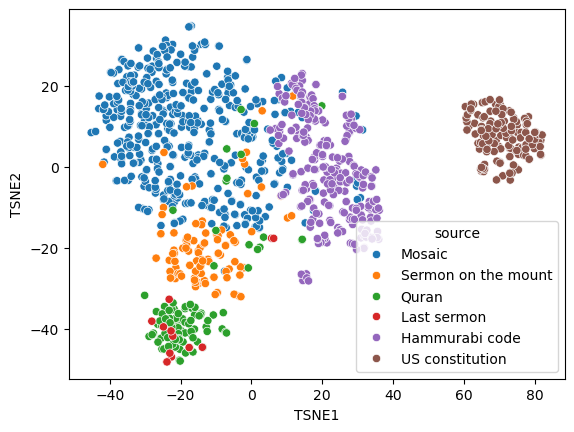

In [127]:
tsne = TSNE(random_state=tsne_rand_state)
tsne_clustering_df = pd.DataFrame(
    tsne.fit_transform(ethics_embeddings_dfs['clustering']),
    index=ethics_embeddings_dfs['clustering'].index,
    columns=['TSNE1', 'TSNE2'])
tsne_clustering_df = tsne_clustering_df.merge(combined_df.reindex(['source'], axis=1), left_index=True, right_index=True)
tsne_clustering_df.head()
tsne_clustering_df.tail()
sns.scatterplot(data=tsne_clustering_df, x='TSNE1', y='TSNE2', hue='source');

### KMeans with t-SNE

(-0.2, 1.0)

(0.0, 1103.0)

KMeans(n_clusters=2, random_state=22)

For n_clusters = 2 The average silhouette_score is :0.465


Text(-0.05, 349.0, '0')

Text(-0.05, 895.5, '1')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 2')

(-0.2, 1.0)

(0.0, 1113.0)

KMeans(n_clusters=3, random_state=22)

For n_clusters = 3 The average silhouette_score is :0.432


Text(-0.05, 227.0, '0')

Text(-0.05, 639.5, '1')

Text(-0.05, 969.0, '2')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 3')

(-0.2, 1.0)

(0.0, 1123.0)

KMeans(n_clusters=4, random_state=22)

For n_clusters = 4 The average silhouette_score is :0.532


Text(-0.05, 182.5, '0')

Text(-0.05, 542.5, '1')

Text(-0.05, 848.0, '2')

Text(-0.05, 1044.5, '3')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

(-0.2, 1.0)

(0.0, 1133.0)

KMeans(n_clusters=5, random_state=22)

For n_clusters = 5 The average silhouette_score is :0.498


Text(-0.05, 160.0, '0')

Text(-0.05, 422.0, '1')

Text(-0.05, 655.0, '2')

Text(-0.05, 854.5, '3')

Text(-0.05, 1028.0, '4')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 5')

(-0.2, 1.0)

(0.0, 1143.0)

KMeans(n_clusters=6, random_state=22)

For n_clusters = 6 The average silhouette_score is :0.481


Text(-0.05, 138.5, '0')

Text(-0.05, 376.5, '1')

Text(-0.05, 557.5, '2')

Text(-0.05, 707.5, '3')

Text(-0.05, 868.0, '4')

Text(-0.05, 1046.5, '5')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 6')

(-0.2, 1.0)

(0.0, 1153.0)

KMeans(n_clusters=7, random_state=22)

For n_clusters = 7 The average silhouette_score is :0.460


Text(-0.05, 106.5, '0')

Text(-0.05, 311.0, '1')

Text(-0.05, 486.5, '2')

Text(-0.05, 632.5, '3')

Text(-0.05, 791.0, '4')

Text(-0.05, 948.5, '5')

Text(-0.05, 1084.5, '6')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 7')

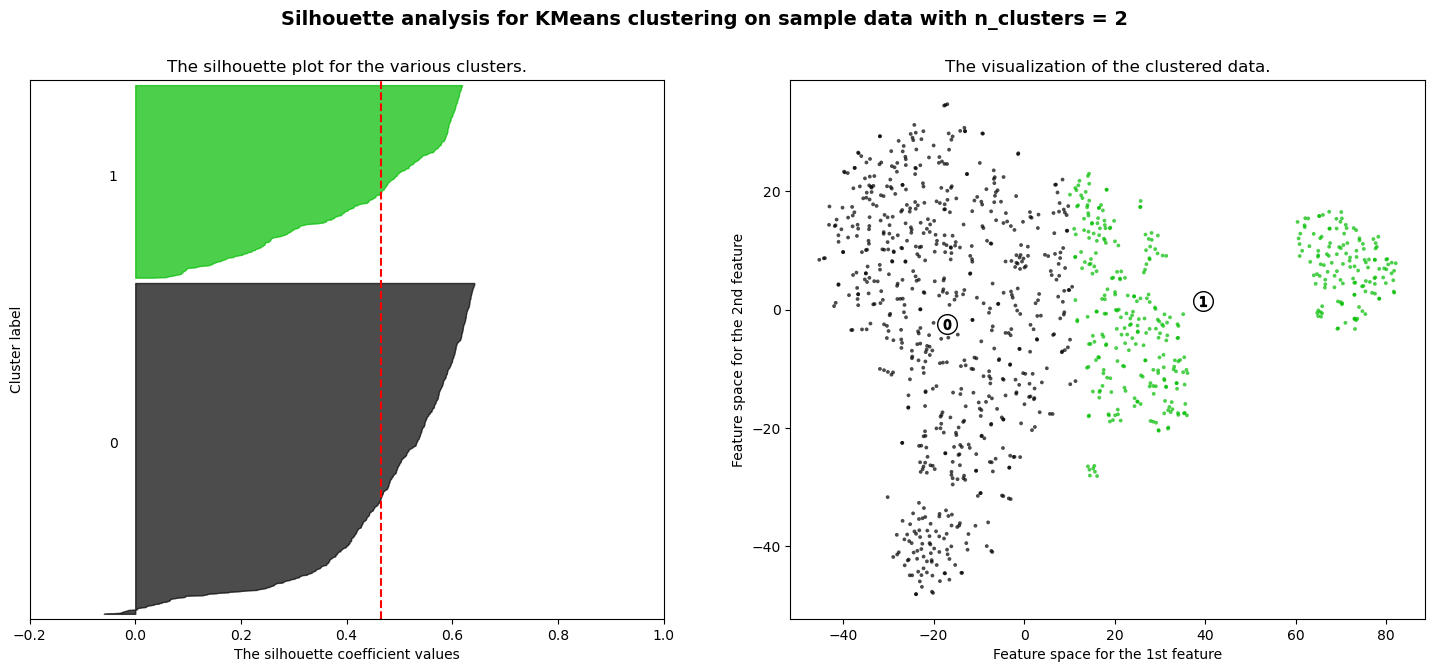

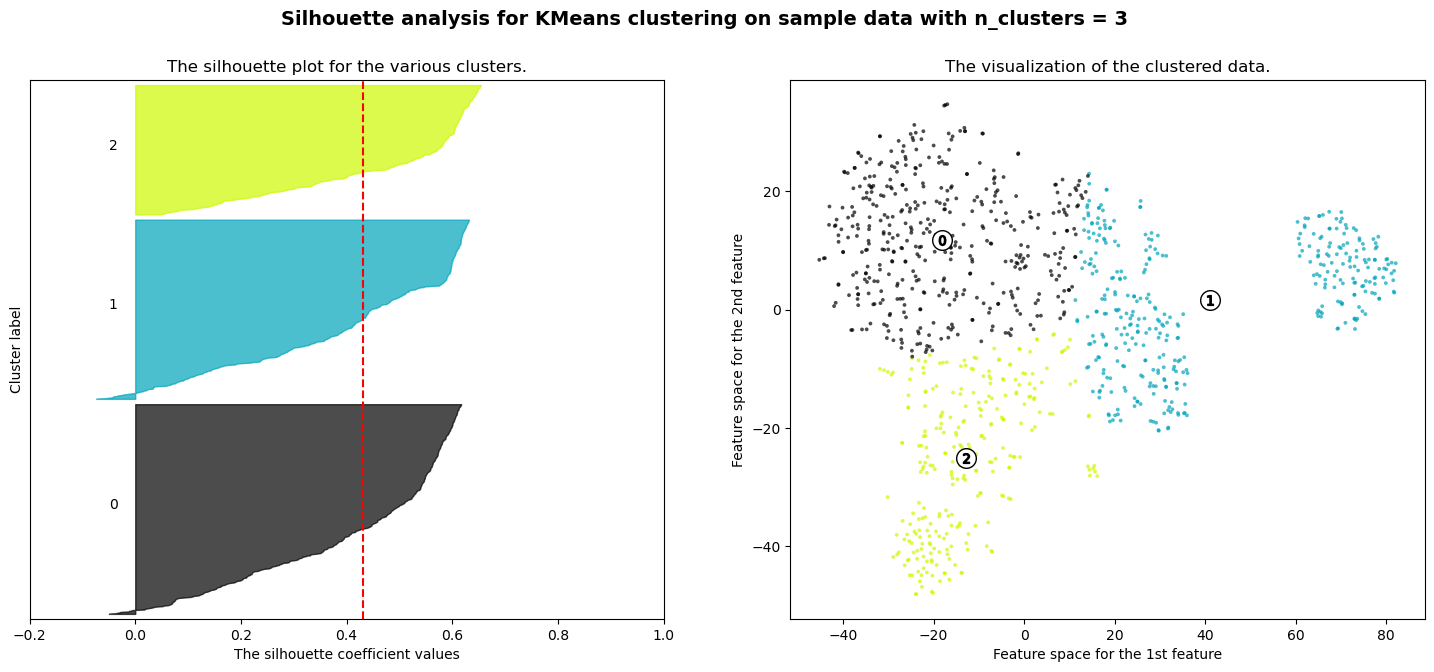

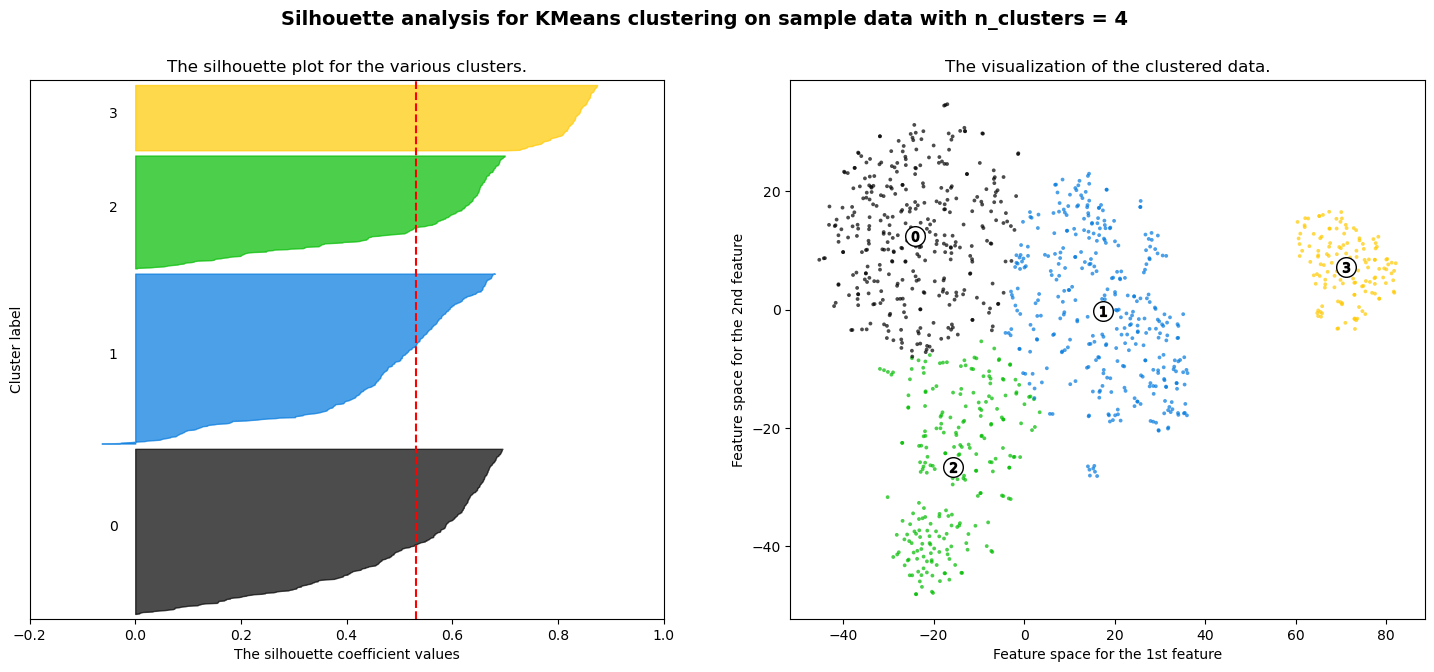

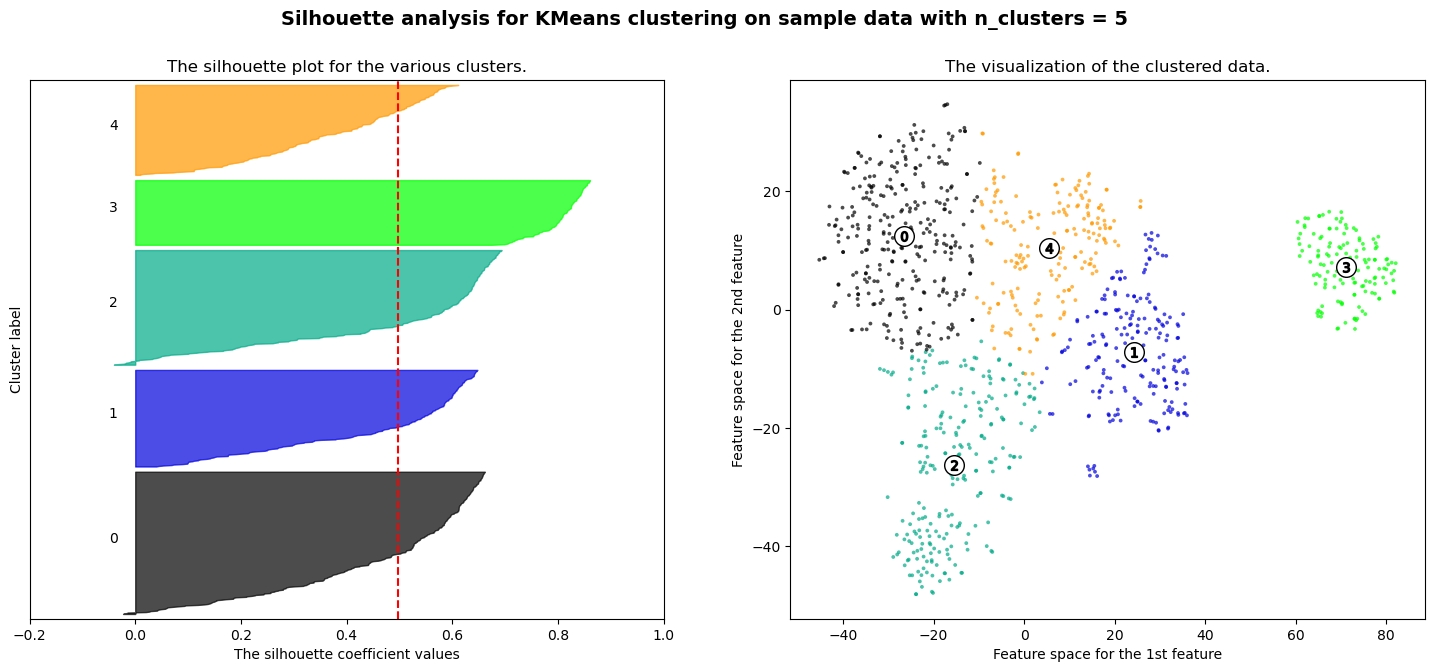

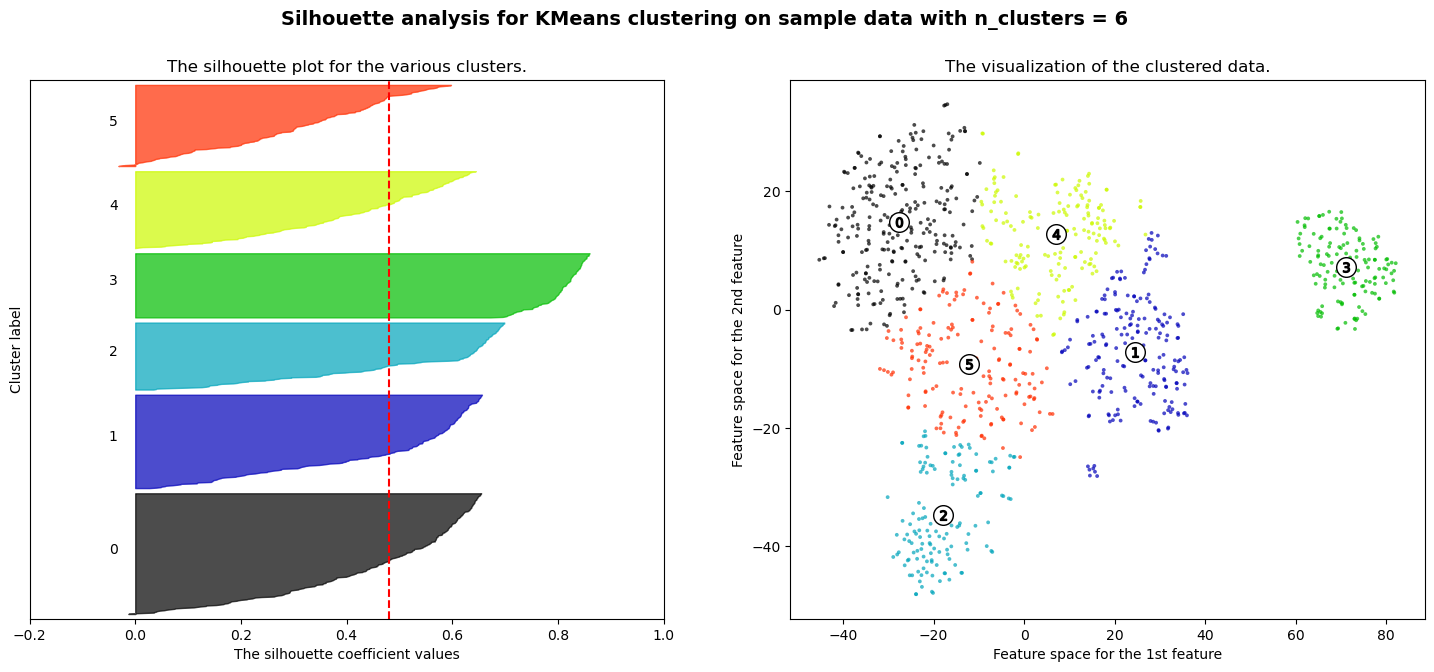

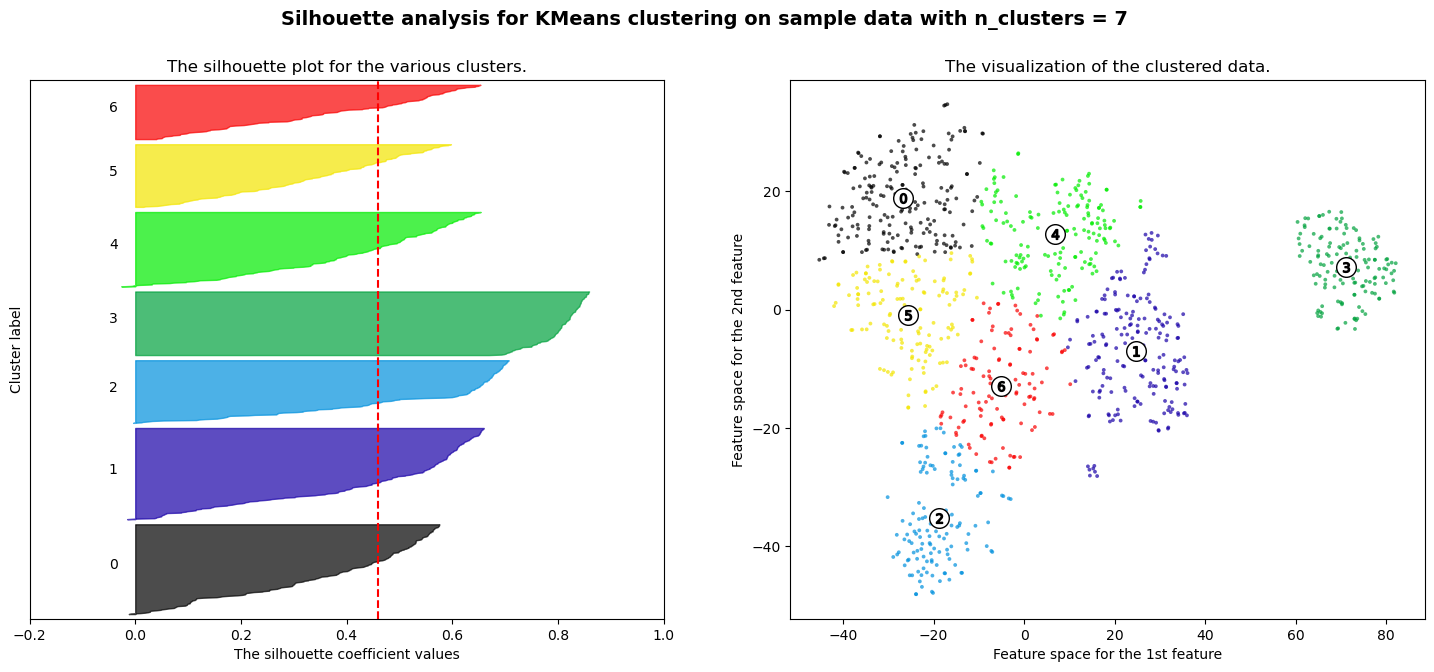

In [ ]:
# Modified from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
n_clusters_to_test = [i for i in range(2, 8)]
sum_of_sqr_distances = []
silhouette_scores = []
cluster_silhouette_scores = []
v_measures = []
for n_clusters in n_clusters_to_test:
    tc_df = tsne_clustering_df.copy()

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(tc_df) + (n_clusters + 1) * 10])

    km = KMeans(n_clusters=n_clusters, random_state=kmeans_rand_state)
    km.fit(tc_df.reindex(['TSNE1', 'TSNE2'], axis=1))
    cluster_labels = km.predict(tc_df.reindex(['TSNE1', 'TSNE2'], axis=1))
    tc_df['cluster'] = cluster_labels
    sum_of_sqr_distances.append(km.inertia_)
    v_measures.append(v_measure_score(tc_df['source'], tc_df['cluster']))
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters.
    silhouette_avg = silhouette_score(tc_df.reindex(['TSNE1', 'TSNE2'], axis=1), tc_df['cluster'])
    silhouette_scores.append(silhouette_avg)
    print(f'For n_clusters = {n_clusters} The average silhouette_score is :{silhouette_avg:.3f}')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tc_df.reindex(['TSNE1', 'TSNE2'], axis=1), tc_df['cluster'])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        # 10 for the 0 samples
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    # Clear the yaxis labels / ticks
    ax1.set_yticks([])
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        tc_df['TSNE1'], tc_df['TSNE2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [61]:
for i, v in enumerate(v_measures):
    f'{i + 2} clusters v-measure: {v:.3f}, silhouette average: {silhouette_scores[i]:.3f}, inertia: {sum_of_sqr_distances[i]:.3f}'

'2 clusters v-measure: 0.480, silhouette average: 0.465, inertia: 689489.438'

'3 clusters v-measure: 0.535, silhouette average: 0.432, inertia: 462972.562'

'4 clusters v-measure: 0.643, silhouette average: 0.532, inertia: 218820.562'

'5 clusters v-measure: 0.602, silhouette average: 0.498, inertia: 167256.812'

'6 clusters v-measure: 0.613, silhouette average: 0.481, inertia: 130333.281'

'7 clusters v-measure: 0.592, silhouette average: 0.460, inertia: 111061.125'

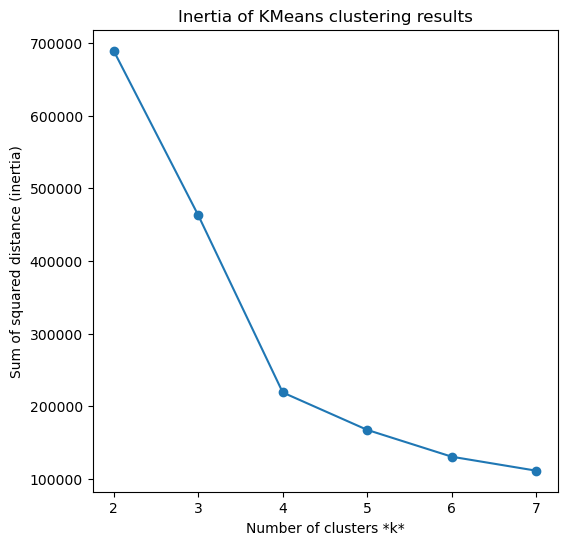

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(n_clusters_to_test, sum_of_sqr_distances, '-o')
plt.title('Inertia of KMeans clustering results')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (inertia)');

In [128]:
# Use the same random_state to ensure the KMeans results are equivalent
final_kmeans = KMeans(n_clusters=4, random_state=kmeans_rand_state)
final_kmeans.fit(tsne_clustering_df.reindex(['TSNE1', 'TSNE2'], axis=1))
cluster_labels = final_kmeans.predict(tsne_clustering_df.reindex(['TSNE1', 'TSNE2'], axis=1))
tsne_clustering_df['cluster'] = cluster_labels
# tsne_clustering_df['cluster'] = tsne_clustering_df['cluster'] + 1
tsne_clustering_df = tsne_clustering_df.rename({'TSNE1': 't-SNE 1', 'TSNE2': 't-SNE 2', 'cluster': 'Cluster', 'source': 'Source'}, axis=1)
tsne_clustering_df.head()

KMeans(n_clusters=4, random_state=22)

,t-SNE 1,t-SNE 2,Source,Cluster
0,-19.754309,9.793135,Mosaic,0
1,-22.860676,14.688944,Mosaic,0
2,-38.699135,2.448932,Mosaic,0
3,-30.159050,11.417932,Mosaic,0
4,-31.324795,10.197248,Mosaic,0


In [129]:
final_kmeans_cluster_centers = pd.DataFrame(final_kmeans.cluster_centers_)
final_kmeans_cluster_centers['Cluster'] = final_kmeans_cluster_centers.index.values
final_kmeans_cluster_centers

,0,1,Cluster
0,-24.053885,12.471596,0
1,17.544827,-0.196314,1
2,-15.744087,-26.636744,2
3,71.240562,7.286123,3


In [130]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(tsne_clustering_df.reindex(['t-SNE 1', 't-SNE 2'], axis=1), tsne_clustering_df['Cluster'])
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(tsne_clustering_df.reindex(['t-SNE 1', 't-SNE 2'], axis=1), tsne_clustering_df['Cluster'])
min(sample_silhouette_values)

np.float32(-0.063721895)

(-0.2, 1.0)

(0.0, 1153.0)

'cluster i 345'

Text(-0.05, 182.5, '0')

'cluster i 355'

Text(-0.05, 542.5, '1')

'cluster i 236'

Text(-0.05, 848.0, '2')

'cluster i 137'

Text(-0.05, 1044.5, '3')

Text(0.5, 1.0, 'Silhouette analysis for KMeans clusters (k=4)')

Text(0.5, 0, 'The sample silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

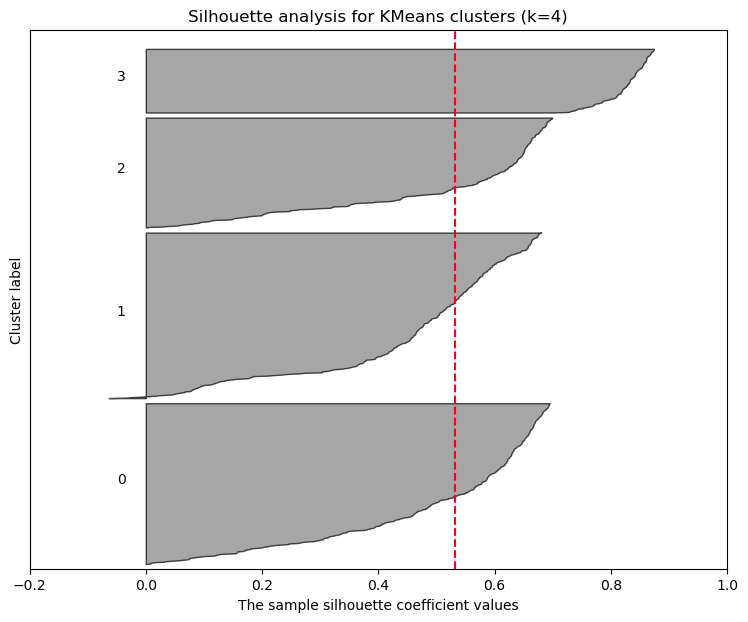

In [131]:
# Modified from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
fig, ax1 = plt.subplots()
fig.set_size_inches(9, 7)
# The silhouette coefficient can range from -1, 1
# The minimum for these examples is about -0.064
ax1.set_xlim([-0.2, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(tsne_clustering_df) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(4):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[tsne_clustering_df['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    f'cluster i {size_cluster_i}'
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor='grey',
        edgecolor='black',
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette analysis for KMeans clusters (k=4)")
ax1.set_xlabel("The sample silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\4090377799.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  cluster_ax = sns.scatterplot(data=tsne_clustering_df, x='t-SNE 1', y='t-SNE 2', style='Cluster', hue='Source', palette=sns.color_palette("tab10"))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\4090377799.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  cluster_ax = sns.scatterplot(data=final_kmeans_cluster_centers, x=0, y=1, style=final_kmeans_cluster_centers.index.values, s=75, hue='Cluster', palette=['grey'], edgecolors='black', legend=False, ax=cluster_ax)


Text(0.5, 1.0, 'KMeans clustering (k=4) of embedded ethics transormed with t-SNE')

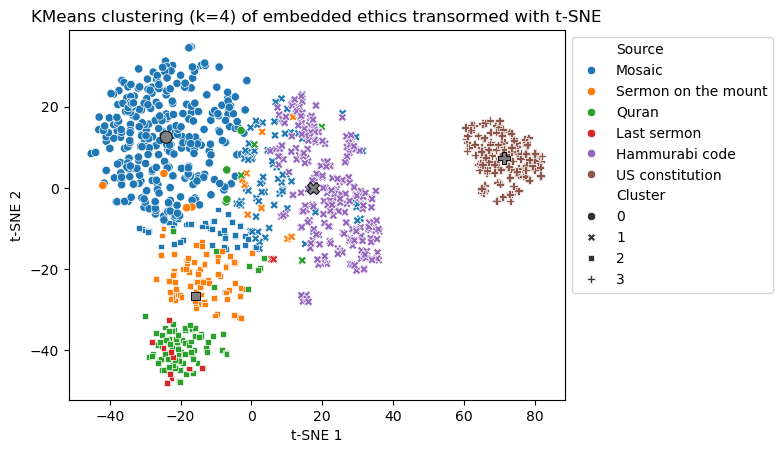

In [132]:
cluster_ax = sns.scatterplot(data=tsne_clustering_df, x='t-SNE 1', y='t-SNE 2', style='Cluster', hue='Source', palette=sns.color_palette("tab10"))
cluster_ax = sns.scatterplot(data=final_kmeans_cluster_centers, x=0, y=1, style=final_kmeans_cluster_centers.index.values, s=75, hue='Cluster', palette=['grey'], edgecolors='black', legend=False, ax=cluster_ax)
cluster_ax.set_title('KMeans clustering (k=4) of embedded ethics transormed with t-SNE')
sns.move_legend(cluster_ax, 'upper left', bbox_to_anchor=(1, 1))

In [133]:
tsne_crosstab = pd.crosstab(tsne_clustering_df['Source'], tsne_clustering_df['Cluster'], normalize='index')
tsne_crosstab = tsne_crosstab.reindex(
    ['Mosaic', 'Sermon on the mount', 'Quran', 'Last sermon', 'Hammurabi code', 'US constitution'])
tsne_crosstab

Cluster,0,1,2,3
Source,,,,
Mosaic,0.718550,0.174840,0.106610,0.0
Sermon on the mount,0.037383,0.112150,0.850467,0.0
Quran,0.043011,0.053763,0.903226,0.0
Last sermon,0.000000,0.153846,0.846154,0.0
Hammurabi code,0.000000,1.000000,0.000000,0.0
US constitution,0.000000,0.000000,0.000000,1.0


Text(0.5, 1.0, 'The ratio of ethics from a data source in each cluster')

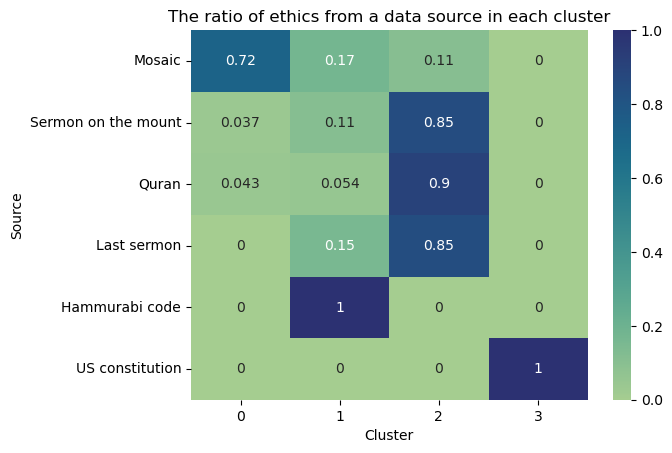

In [ ]:
heatmap_ax = sns.heatmap(tsne_crosstab, vmin=0, vmax=1, cmap='crest', annot=True)
heatmap_ax.set_title('The ratio of ethics from a data source in each cluster')

### Problems with clutering with t-SNE mapped data

##### The global distances between data points and cluster centers can be distorted by mapping to a 2 dimensional space with t-SNE. In order to get a better representation, let's:
1. Model the embeddings directly with k-means
2. Assign cluster labels to data points based on this k-means model
3. Determine the cluster centers
4. Map the data points and cluster centers together with t-SNE

In [135]:
# Modified from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
n_clusters_to_test = [i for i in range(2, 8)]
sum_of_sqr_distances = []
silhouette_scores = []
cluster_silhouette_scores = []
v_measures = []
for n_clusters in n_clusters_to_test:
    tc_df = ethics_embeddings_dfs['clustering'].copy()

    km = KMeans(n_clusters=n_clusters, random_state=kmeans_rand_state)
    km.fit(tc_df)
    cluster_labels = km.predict(tc_df)
    tc_df['cluster'] = cluster_labels
    sum_of_sqr_distances.append(km.inertia_)

    tc_df = tc_df.merge(combined_df.reindex(['source'], axis=1), left_index=True, right_index=True)

    v_measures.append(v_measure_score(tc_df['source'], tc_df['cluster']))
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters.
    silhouette_avg = silhouette_score(tc_df.drop(['source', 'cluster'], axis=1), tc_df['cluster'])
    silhouette_scores.append(silhouette_avg)

for i, v in enumerate(v_measures):
    f'{i + 2} clusters v-measure: {v:.3f}, silhouette average: {silhouette_scores[i]:.3f}, inertia: {sum_of_sqr_distances[i]:.3f}'

KMeans(n_clusters=2, random_state=22)

KMeans(n_clusters=3, random_state=22)

KMeans(n_clusters=4, random_state=22)

KMeans(n_clusters=5, random_state=22)

KMeans(n_clusters=6, random_state=22)

KMeans(n_clusters=7, random_state=22)

'2 clusters v-measure: 0.469, silhouette average: 0.069, inertia: 558.442'

'3 clusters v-measure: 0.632, silhouette average: 0.065, inertia: 520.876'

'4 clusters v-measure: 0.732, silhouette average: 0.073, inertia: 501.208'

'5 clusters v-measure: 0.623, silhouette average: 0.060, inertia: 492.222'

'6 clusters v-measure: 0.637, silhouette average: 0.056, inertia: 484.311'

'7 clusters v-measure: 0.606, silhouette average: 0.054, inertia: 479.204'

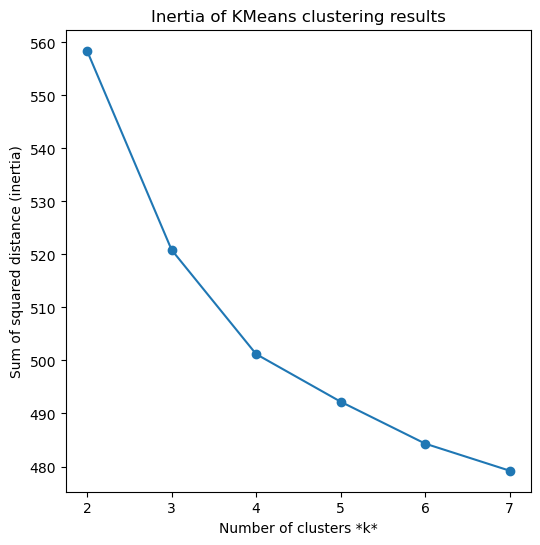

In [136]:
plt.figure(figsize=(6, 6))
plt.plot(n_clusters_to_test, sum_of_sqr_distances, '-o')
plt.title('Inertia of KMeans clustering results')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (inertia)');

In [145]:
tsne_clustering_df.head()

,t-SNE 1,t-SNE 2,Source,Cluster
0,-19.754309,9.793135,Mosaic,0
1,-22.860676,14.688944,Mosaic,0
2,-38.699135,2.448932,Mosaic,0
3,-30.159050,11.417932,Mosaic,0
4,-31.324795,10.197248,Mosaic,0


In [144]:
final_clustering_df = ethics_embeddings_dfs['clustering'].copy()
final_clustering_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.012819,0.049658,-0.007493,0.014079,-0.023870,0.038079,0.059090,0.010332,-0.008598,0.032094,...,0.031898,0.010433,0.007807,-0.001684,0.022895,0.005108,-0.050164,-0.035121,0.041157,-0.014167
1,0.031423,0.008716,0.027964,-0.032539,0.013522,-0.011224,-0.024953,-0.052130,-0.018533,0.035958,...,0.021541,0.042588,-0.013276,0.024843,-0.007270,-0.009141,-0.057306,0.004277,0.011008,-0.042523
2,0.050230,0.067548,-0.013850,-0.026679,-0.014274,-0.029015,-0.010413,0.032898,-0.073372,0.021695,...,0.070667,-0.016255,-0.001357,0.066926,0.012943,0.000040,-0.066872,-0.051267,0.027992,-0.046539
3,0.051076,0.027016,0.038871,-0.055560,0.009340,-0.028536,0.020736,0.040093,0.007227,0.030335,...,0.028831,0.008020,-0.009496,0.045558,-0.002884,-0.001869,-0.048945,0.015589,0.048225,-0.052777
4,0.058761,0.025829,0.029559,0.025174,-0.012287,-0.031244,0.004935,0.016847,-0.022404,0.016241,...,0.030617,-0.002962,-0.039964,0.015464,-0.047413,-0.022456,-0.102150,-0.025450,0.041138,-0.043831


In [157]:
final_clustering_df = ethics_embeddings_dfs['clustering'].copy()
final_clustering_df = final_clustering_df.merge(
    combined_df.reindex(['source'], axis=1), left_index=True, right_index=True)

# Use the same random_state to ensure the KMeans results are equivalent
final_kmeans = KMeans(n_clusters=4, random_state=kmeans_rand_state)
final_kmeans.fit(final_clustering_df.drop(['source'], axis=1))
cluster_labels = final_kmeans.predict(final_clustering_df.drop(['source'], axis=1))
final_clustering_df['cluster'] = cluster_labels
final_clustering_df = final_clustering_df.rename({'source': 'Source', 'cluster': 'Cluster'}, axis=1)

final_kmeans_cluster_centers = pd.DataFrame(final_kmeans.cluster_centers_)
final_kmeans_cluster_centers['Cluster'] = final_kmeans_cluster_centers.index.values
final_kmeans_cluster_centers['Source'] = pd.NA


KMeans(n_clusters=4, random_state=22)

In [147]:
# Replace the cluster labels with the results of KMeans applied to all the dimesions
tsne_clustering_df['Cluster'] = cluster_labels

In [158]:
final_clustering_df.head()
tsne_clustering_df.head()
final_kmeans_cluster_centers

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,Source,Cluster
0,0.012819,0.049658,-0.007493,0.014079,-0.023870,0.038079,0.059090,0.010332,-0.008598,0.032094,...,0.007807,-0.001684,0.022895,0.005108,-0.050164,-0.035121,0.041157,-0.014167,Mosaic,2
1,0.031423,0.008716,0.027964,-0.032539,0.013522,-0.011224,-0.024953,-0.052130,-0.018533,0.035958,...,-0.013276,0.024843,-0.007270,-0.009141,-0.057306,0.004277,0.011008,-0.042523,Mosaic,0
2,0.050230,0.067548,-0.013850,-0.026679,-0.014274,-0.029015,-0.010413,0.032898,-0.073372,0.021695,...,-0.001357,0.066926,0.012943,0.000040,-0.066872,-0.051267,0.027992,-0.046539,Mosaic,0
3,0.051076,0.027016,0.038871,-0.055560,0.009340,-0.028536,0.020736,0.040093,0.007227,0.030335,...,-0.009496,0.045558,-0.002884,-0.001869,-0.048945,0.015589,0.048225,-0.052777,Mosaic,0
4,0.058761,0.025829,0.029559,0.025174,-0.012287,-0.031244,0.004935,0.016847,-0.022404,0.016241,...,-0.039964,0.015464,-0.047413,-0.022456,-0.102150,-0.025450,0.041138,-0.043831,Mosaic,0


,t-SNE 1,t-SNE 2,Source,Cluster
0,-19.754309,9.793135,Mosaic,2
1,-22.860676,14.688944,Mosaic,0
2,-38.699135,2.448932,Mosaic,0
3,-30.159050,11.417932,Mosaic,0
4,-31.324795,10.197248,Mosaic,0


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,Cluster,Source
0,0.053449,0.025988,0.013540,-0.023929,-0.007224,0.005540,0.014251,0.002871,-0.022057,0.038590,...,-0.011227,0.023117,-0.006231,0.000011,-0.051210,-0.004624,0.038784,-0.037985,0,<NA>
1,0.030907,0.044931,-0.005956,-0.018036,-0.007731,0.019143,0.010094,-0.004669,-0.034870,0.055120,...,-0.019272,0.045421,-0.006858,0.029772,-0.001163,-0.049809,0.008168,-0.032174,1,<NA>
2,0.027973,0.020003,0.016864,0.005329,-0.012906,0.027874,0.008814,0.020477,-0.020761,0.021250,...,-0.021578,0.035987,-0.001487,0.010619,-0.046806,-0.036482,0.024622,-0.035638,2,<NA>
3,0.042214,0.035273,0.024353,0.001929,0.005297,0.005557,-0.011272,0.005885,-0.024635,0.043817,...,-0.037393,0.031755,0.016344,0.001959,-0.045934,-0.016749,0.048528,-0.035632,3,<NA>


In [ ]:
# Modified from: https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/tutorials/anomaly_detection.ipynb
def get_centroids(tsne_df):
  # Get the centroid of each cluster
  centroids = tsne_df.groupby('Cluster').mean()
  return centroids

tsne_centroids = get_centroids(tsne_clustering_df.drop(['Source'], axis=1))
tsne_centroids

,t-SNE 1,t-SNE 2
Cluster,,
0,-20.935049,10.024807
1,71.240547,7.286123
2,-13.179845,-24.406387
3,20.051615,0.033271


C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\272219221.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  cluster_ax = sns.scatterplot(data=tsne_clustering_df, x='t-SNE 1', y='t-SNE 2', style='Cluster', hue='Source', palette=sns.color_palette("tab10"))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\272219221.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  cluster_ax = sns.scatterplot(data=tsne_centroids, x='t-SNE 1', y='t-SNE 2', style=tsne_centroids.index.values, s=75, hue='Cluster', palette=['grey'], edgecolors='black', legend=False, ax=cluster_ax)


Text(0.5, 1.0, 'KMeans clustering (k=4) of embedded ethics')

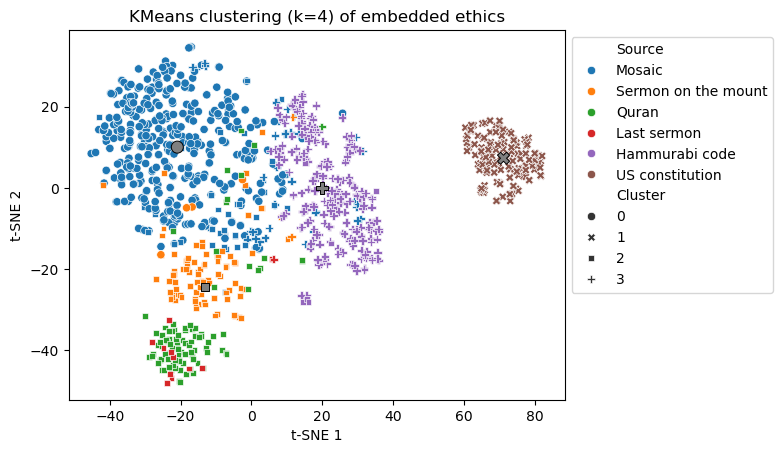

In [163]:
cluster_ax = sns.scatterplot(data=tsne_clustering_df, x='t-SNE 1', y='t-SNE 2', style='Cluster', hue='Source', palette=sns.color_palette("tab10"))
cluster_ax = sns.scatterplot(data=tsne_centroids, x='t-SNE 1', y='t-SNE 2', style=tsne_centroids.index.values, s=75, hue='Cluster', palette=['grey'], edgecolors='black', legend=False, ax=cluster_ax)
cluster_ax.set_title('KMeans clustering (k=4) of embedded ethics')
sns.move_legend(cluster_ax, 'upper left', bbox_to_anchor=(1, 1))

#### Calculating the cluster centers with the t-SNE reduced dimensions is probably fine for the visualization, but let's figure out the cluster centers with the full dimension embeddings and then map all the data points at the same time.

In [159]:
final_clustering_df = pd.concat([final_clustering_df, final_kmeans_cluster_centers], ignore_index=True)

tsne = TSNE(random_state=tsne_rand_state)
final_tsne_clustering_df = pd.DataFrame(
    tsne.fit_transform(final_clustering_df.drop(['Cluster', 'Source'], axis=1)),
    index=final_clustering_df.index,
    columns=['t-SNE 1', 't-SNE 2'])

final_tsne_clustering_df = final_tsne_clustering_df.merge(final_clustering_df.reindex(['Cluster', 'Source'], axis=1), left_index=True, right_index=True)
final_tsne_clustering_df.head()
final_tsne_clustering_df.tail()

C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\3853789263.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_clustering_df = pd.concat([final_clustering_df, final_kmeans_cluster_centers], ignore_index=True)


,t-SNE 1,t-SNE 2,Cluster,Source
0,-24.815281,7.594405,2,Mosaic
1,-22.665512,27.045542,0,Mosaic
2,-23.699421,21.030392,0,Mosaic
3,-16.269676,24.121187,0,Mosaic
4,-15.728036,22.791136,0,Mosaic


,t-SNE 1,t-SNE 2,Cluster,Source
1072,1.803964,-45.364429,1,US constitution
1073,-8.309483,15.723306,0,<NA>
1074,3.951638,-42.682659,1,<NA>
1075,-9.322789,-6.445813,2,<NA>
1076,13.774222,1.395331,3,<NA>


C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\109319726.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  cluster_ax = sns.scatterplot(data=final_tsne_clustering_df.loc[~final_tsne_clustering_df['Source'].isna()], x='t-SNE 1', y='t-SNE 2', style='Cluster', hue='Source', palette=sns.color_palette("tab10"))
C:\Users\Jonah\AppData\Local\Temp\ipykernel_34940\109319726.py:2: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  cluster_ax = sns.scatterplot(data=final_tsne_clustering_df.loc[final_tsne_clustering_df['Source'].isna()], x='t-SNE 1', y='t-SNE 2', style='Cluster', s=75, hue='Cluster', palette=['grey'], edgecolors='black', legend=False, ax=cluster_ax)


Text(0.5, 1.0, 'KMeans clustering (k=4) of embedded ethics')

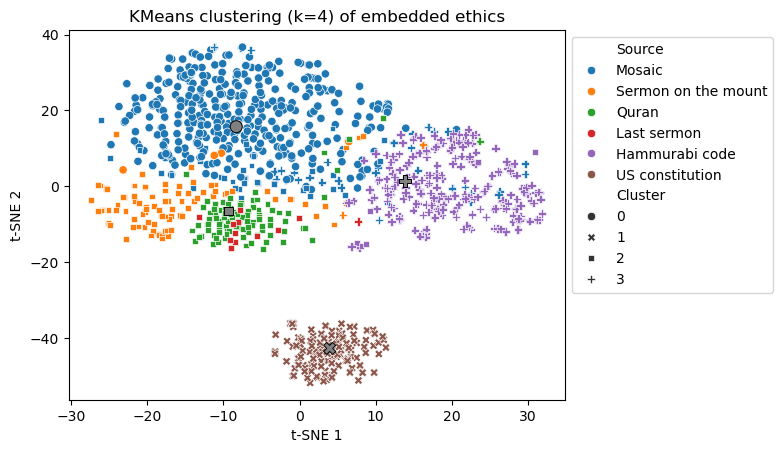

In [160]:
cluster_ax = sns.scatterplot(data=final_tsne_clustering_df.loc[~final_tsne_clustering_df['Source'].isna()], x='t-SNE 1', y='t-SNE 2', style='Cluster', hue='Source', palette=sns.color_palette("tab10"))
cluster_ax = sns.scatterplot(data=final_tsne_clustering_df.loc[final_tsne_clustering_df['Source'].isna()], x='t-SNE 1', y='t-SNE 2', style='Cluster', s=75, hue='Cluster', palette=['grey'], edgecolors='black', legend=False, ax=cluster_ax)
cluster_ax.set_title('KMeans clustering (k=4) of embedded ethics')
sns.move_legend(cluster_ax, 'upper left', bbox_to_anchor=(1, 1))

In [161]:
tsne_crosstab = pd.crosstab(final_tsne_clustering_df['Source'], final_tsne_clustering_df['Cluster'], normalize='index')
tsne_crosstab = tsne_crosstab.reindex(
    ['Mosaic', 'Sermon on the mount', 'Quran', 'Last sermon', 'Hammurabi code', 'US constitution'])
tsne_crosstab

Cluster,0,1,2,3
Source,,,,
Mosaic,0.840085,0.0,0.076759,0.083156
Sermon on the mount,0.037383,0.0,0.943925,0.018692
Quran,0.000000,0.0,0.989247,0.010753
Last sermon,0.000000,0.0,0.923077,0.076923
Hammurabi code,0.000000,0.0,0.027559,0.972441
US constitution,0.000000,1.0,0.000000,0.000000


Text(0.5, 1.0, 'The ratio of ethics from a data source in each cluster')

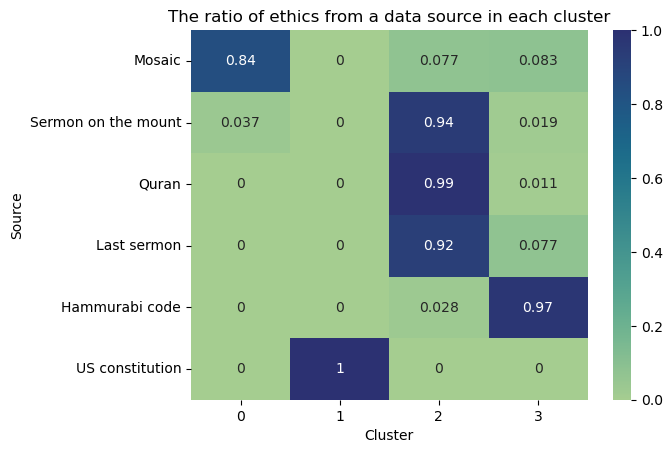

In [162]:
heatmap_ax = sns.heatmap(tsne_crosstab, vmin=0, vmax=1, cmap='crest', annot=True)
heatmap_ax.set_title('The ratio of ethics from a data source in each cluster')

In [182]:
cluster_distances = pairwise_distances(
    final_kmeans_cluster_centers.drop(['Source', 'Cluster'], axis=1),
    final_kmeans_cluster_centers.drop(['Source', 'Cluster'], axis=1))
cluster_distances = pd.DataFrame(
    index=final_kmeans_cluster_centers['Cluster'],
    columns=final_kmeans_cluster_centers['Cluster'],
    data=cluster_distances)
cluster_distances = cluster_distances.map(round, ndigits=3)
cluster_distances

Cluster,0,1,2,3
Cluster,,,,
0,0.000,0.613,0.361,0.399
1,0.613,0.000,0.605,0.610
2,0.361,0.605,0.000,0.434
3,0.399,0.610,0.434,0.000


In [183]:
cluster_distances_ranks = pd.DataFrame(index=cluster_distances.index, columns=cluster_distances.columns)
for i, row in cluster_distances.iterrows():
    cluster_distances_ranks.loc[i] = row.rank()
cluster_distances_ranks

Cluster,0,1,2,3
Cluster,,,,
0,1.0,4.0,2.0,3.0
1,4.0,1.0,2.0,3.0
2,2.0,4.0,1.0,3.0
3,2.0,4.0,3.0,1.0
